## 1. Import Module

In [1524]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

## 2. Các UDF Function sử dụng trong bài

In [1525]:
# Dùng để in danh sách các giá trị trong các cột để kiểm tra
def print_info_all_columns(df, lst):
    i = 1

    for obj in lst:
        print(f'{i}/{obj}\t{len(df[obj].unique())}: {df[obj].unique() if len(df[obj].unique()) <= 50 else ""}')

        i +=1

In [1526]:
def print_info_all_columns_numbers(df, lst):
    i = 1

    for obj in lst:
        print(f'{i}/{obj}\t{len(df[obj].unique())}: {df[obj].unique() if len(df[obj].unique()) < 150 else ""}')

        i +=1

In [1527]:
def Split_Car_Name(car_name):
    return car_name.split(" ")[0]

In [1528]:
def words_to_numbers(text):
    word_to_num = {
        'zero': 0,
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5,
        'six': 6,
        'seven': 7,
        'eight': 8,
        'nine': 9,
        'ten': 10,
        'eleven': 11,
        'twelve': 12,
        'thirteen': 13,
        'fourteen': 14,
        'fifteen': 15,
        'sixteen': 16,
        'seventeen': 17,
        'eighteen': 18,
        'nineteen': 19,
        'twenty': 20,
        'thirty': 30,
        'forty': 40,
        'fifty': 50,
        'sixty': 60,
        'seventy': 70,
        'eighty': 80,
        'ninety': 90,
        'hundred': 100,
        'thousand': 1000,
        'million': 1000000,
        'billion': 1000000000,
    }

    # Split the text into words
    words = text.lower().split()

    result = 0
    temp_result = 0
    for word in words:
        if word == 'and':
            continue
        if word in word_to_num:
            if word == 'hundred':
                temp_result *= word_to_num[word]
            else:
                temp_result += word_to_num[word]
        elif '-' in word:
            parts = word.split('-')
            temp = 0
            for part in parts:
                temp += word_to_num[part]
            temp_result += temp
        else:
            result += temp_result * word_to_num[word]
            temp_result = 0
    
    return result + temp_result

In [1529]:
def all_infomation_continuous_variable(df, col_name):
    import numpy as np
    import scipy

    col_Median = df[col_name].median()
    col_Mode = df[col_name].mode()
    col_Q1 = np.percentile(df[col_name], 25)
    col_Q3 = np.percentile(df[col_name], 75)
    col_IQR = scipy.stats.iqr(df[col_name])
    col_Range = df[col_name].max() - df[col_name].min()
    col_Var = df[col_name].var()
    col_Std = df[col_name].std()
    col_Skew = df[col_name].skew()
    col_Kur = df[col_name].kurtosis()

    print(f'Các thông số thống kê cơ bản của {col_name}')
    print(df[col_name].describe(include='all'))

    print(f'{col_name} Median: {col_Median}')
    print(f'{col_name} Mode: {col_Mode}')
    print(f'{col_name} Q1: {col_Q1}')
    print(f'{col_name} Q3: {col_Q3}')
    print(f'{col_name} IQR: {col_IQR}')
    print(f'{col_name} Range: {col_Range}')
    print(f'{col_name} Var: {col_Var}')
    print(f'{col_name} Std: {col_Std}')
    print(f'{col_name} Skew: {col_Skew}')
    print(f'{col_name} Kurtosis: {col_Kur}')

    if col_Skew > 0:
        print('Phân phối lệch phải')
    elif col_Skew == 0:
        print('Phân phối chuẩn')
    else:
        print('Phân phối lệch trái')

    print('--------------------------------------------------------')
    print('Kiểm tra số lượng Outlier!')

    n_O_upper = df[df[col_name] > col_Q3 + 1.5 * col_IQR].shape[0]
    n_O_lower = df[df[col_name] < col_Q1 - 1.5 * col_IQR].shape[0]

    outliers_per = (n_O_upper + n_O_lower) / len(df) * 100

    print(f'Số lượng Outlier bên trên là: {n_O_upper}')
    print(f'Số lượng Outlier bên dưới là: {n_O_lower}')
    print(f'Phần trăm Outlier của cột {col_name} là {outliers_per}')


In [1530]:
def hist_plot_continuous_variable(df, col_name):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col_name], kde=True)

    plt.subplot(1, 2, 2)
    plt.hist(df[col_name])

    plt.show()

In [1531]:
def remove_outliers(df, column_name):
    import numpy as np
    import pandas as pd

    # Lấy các giá trị của cột
    column_values = df[column_name]
    
    # Tính toán Q1, Q3 và IQR
    Q1 = column_values.quantile(0.25)
    Q3 = column_values.quantile(0.75)
    IQR = Q3 - Q1
    
    # Tính toán giới hạn dưới và giới hạn trên
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Loại bỏ các giá trị ngoại lệ
    cleaned_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return cleaned_df

In [1532]:
def all_infomation_categorical_variable(df, col_name):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    col_value_counts = df[col_name].value_counts()

    print(col_value_counts)
    print('-------------------------------------------')

    # Vẽ biểu đồ cột
    ax = col_value_counts.plot(kind='bar', legend=False, figsize=(14, 8))

    # Thêm nhãn dữ liệu
    for i, v in enumerate(col_value_counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
        
    plt.show()

In [1533]:
def Dependent_Continuous_Categorical(df, model_pattern, prob=0.95):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    model = ols(model_pattern, data=df).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)

    alpha = 1 - prob

    if anova_table['PR(>F)'][0] <= alpha:
        print('Dependent')
    else:
        print('Independent')


# model_pattern = 'LotArea ~ C(FullBath)'

# check_dependent_continuous_categorical(df_sub, model_pattern)

In [1534]:
def all_infomation_categorical_vs_continuous(df, col_continuous, col_categorical, model_pattern, prob=0.95):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    import matplotlib.pyplot as plt
    import warnings
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    import seaborn as sns

    warnings.filterwarnings("ignore", category=FutureWarning)

    df_sub = df[[col_categorical, col_continuous]]

    plt.figure(figsize=(12, 10))

    sns.boxplot(x=col_categorical, y=col_continuous, data=df_sub, palette='Set3')

    plt.show()

    # đổi tên cột (đổi dấu . thành dấu _)
    df_sub = df_sub.rename(columns=lambda x: x.replace('.', '_'))

    col_continuous = col_continuous.replace('.', '_')
    col_categorical = col_categorical.replace('.', '_')

    print('----------------------------------------')
    print(f'Kiểm tra 2 biến {col_continuous} và {col_categorical} có phụ thuộc không?')

    model = ols(model_pattern, data=df_sub).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)

    alpha = 1 - prob

    if anova_table['PR(>F)'][0] <= alpha:
        print(f'2 cột {col_continuous} và {col_categorical} có phụ thuộc')
    else:
        print(f'2 cột {col_continuous} và {col_categorical} không phụ thuộc')

    print('----------------------------------------')
    print('Sử dụng tukeyhsd')

    m_comp = pairwise_tukeyhsd(endog=df_sub[col_continuous], groups=df_sub[col_categorical], alpha=1-prob)

    print(m_comp)


## 3. Load Data

In [1535]:
# Các thông tin kết nối đến server
server = '45.117.83.230'
database = 'DA_FINALTEST'
username = 'Student_DA_Q1'
password = '@MindXDream2023'
port = '1433'
driver = '{ODBC Driver 17 for SQL Server}'

In [1536]:
# Chuỗi kết nối
conn_str = f'DRIVER={driver};SERVER={server},{port};DATABASE={database};UID={username};PWD={password}'

In [1537]:
# Thực hiện kết nối
try:
    conn = pyodbc.connect(conn_str)
    print("Kết nối thành công!")
except Exception as e:
    print("Không thể kết nối đến SQL Server:")
    print(e)

Kết nối thành công!


In [1538]:
# tạo cursor
cursor = conn.cursor()

In [1539]:
# Load dữ liệu vào DataFrame
df = pd.read_sql("SELECT * FROM CarPrice_Assignment", conn)

df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,886.0,...,130,mpfi,347.0,268.0,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,886.0,...,130,mpfi,347.0,268.0,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,945.0,...,152,mpfi,268.0,347.0,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,998.0,...,109,mpfi,319.0,34.0,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,994.0,...,136,mpfi,319.0,34.0,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,1091.0,...,141,mpfi,378.0,315.0,95.0,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,1091.0,...,141,mpfi,378.0,315.0,87.0,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,1091.0,...,173,mpfi,358.0,287.0,88.0,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,1091.0,...,145,idi,301.0,34.0,23.0,106,4800,26,27,22470.0


In [1540]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

## 4. EDA dữ liệu

- car_ID: ID duy nhất của mỗi quan sát (Kiểu số nguyên).
- symboling: Được gán cho mức độ rủi ro bảo hiểm của xe. Một giá trị +3 chỉ ra rằng xe có rủi ro cao, -3 chỉ ra rằng xe khá an toàn (Phân loại).
- CarName: Tên loại xe (Phân loại).
- fueltype: Loại nhiên liệu của xe, ví dụ như xăng hoặc diesel (Phân loại).
- aspiration: Loại tăng áp sử dụng trong xe (Phân loại).
- doornumber: Số lượng cửa của xe (Phân loại).
- carbody: Thân xe (Phân loại).
- drivewheel: Bánh lái (Phân loại).
- enginelocation: Vị trí động cơ của xe (Phân loại).
- wheelbase: Khoảng cách trục của xe (Kiểu số).
- carlength: Chiều dài của xe (Kiểu số).
- carwidth: Chiều rộng của xe (Kiểu số).
- carheight: Chiều cao của xe (Kiểu số).
- curbweight: Trọng lượng của xe không bao gồm hành khách hoặc hành lý (Kiểu số).
- enginetype: Loại động cơ (Phân loại).
- cylindernumber: Số lượng xi lanh trong xe (Phân loại).
- enginesize: Kích thước của động cơ (Kiểu số).
- fuelsystem: Hệ thống nhiên liệu của xe (Phân loại).
- boreratio: Tỷ lệ khoan của xe (Kiểu số).
- stroke: Hành trình piston hoặc dung tích bên trong động cơ (Kiểu số).
- compressionratio: Tỷ số nén của xe (Kiểu số).
- horsepower: Mã lực (Kiểu số).
- peakrpm: Vòng quay tối đa của xe (Kiểu số).
- citympg: Mức tiêu thụ nhiên liệu trong thành phố (Kiểu số).
- highwaympg: Mức tiêu thụ nhiên liệu trên đường cao tốc (Kiểu số).
- price(Dependent variable): Giá của xe (Kiểu số).

In [1541]:
# Khai báo biến target của model
target_var = 'price'

In [1542]:
# cột car_ID sẽ không cần khi xây dựng model nên ta sẽ bỏ nó đi
df_new = df.drop(columns=['car_ID'])

df_new

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,886.0,1688.0,...,130,mpfi,347.0,268.0,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,886.0,1688.0,...,130,mpfi,347.0,268.0,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,945.0,1712.0,...,152,mpfi,268.0,347.0,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,998.0,1766.0,...,109,mpfi,319.0,34.0,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,994.0,1766.0,...,136,mpfi,319.0,34.0,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,1091.0,1888.0,...,141,mpfi,378.0,315.0,95.0,114,5400,23,28,16845.0
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,1091.0,1888.0,...,141,mpfi,378.0,315.0,87.0,160,5300,19,25,19045.0
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,1091.0,1888.0,...,173,mpfi,358.0,287.0,88.0,134,5500,18,23,21485.0
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,1091.0,1888.0,...,145,idi,301.0,34.0,23.0,106,4800,26,27,22470.0


In [1543]:
# Kiểm tra kiểu dữ liệu
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [1544]:
# Kiểm tra có dữ liệu null không => không có dữ liệu null
df_new.isnull().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [1545]:
# Phân ra dữ liệu dạng chữ và dạng số và tiến hành phân tích
object_cols = df_new.select_dtypes(include='object').columns.tolist()

object_cols

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [1546]:
numerical_cols = df_new.select_dtypes(exclude='object').columns.tolist()

numerical_cols

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg',
 'price']

In [1547]:
print_info_all_columns(df_new, object_cols)

1/CarName	147: 
2/fueltype	2: ['gas' 'diesel']
3/aspiration	2: ['std' 'turbo']
4/doornumber	2: ['two' 'four']
5/carbody	5: ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
6/drivewheel	3: ['rwd' 'fwd' '4wd']
7/enginelocation	2: ['front' 'rear']
8/enginetype	7: ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
9/cylindernumber	7: ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
10/fuelsystem	8: ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


- Cột CarName sẽ cần xử lý thêm => lấy ra tên hãng xe thay vì full tên của xe như cũ
- Các cột còn lại là biến phân loại => Tuy nhiên cột cylindernumber là kiểu dữ liệu ordinal => sẽ mapping lại

Giải thích thêm 1 chút về fuelsystem => đây là các biến phân loại và không thể sắp xếp nó theo 1 thứ tự nào cả.

- <b>MPFI (Multi-Point Fuel Injection)</b>: MPFI là một hệ thống phun nhiên liệu đa điểm. Trong hệ thống này, mỗi xi lanh của động cơ được trang bị một injector riêng để phun nhiên liệu vào đốt cháy. Hệ thống MPFI thường cung cấp hiệu suất và tiết kiệm nhiên liệu tốt hơn so với các hệ thống phun nhiên liệu khác.
- <b>2BBL (Two-Barrel Carburetor)</b>: 2BBL là viết tắt của Two-Barrel Carburetor, tức là bộ chế hòa khí hai thùng. Carburetor là một bộ phận trong hệ thống nhiên liệu của một số động cơ cũ, trong đó nhiên liệu và không khí được kết hợp trước khi đưa vào buồng đốt. Hệ thống 2BBL có hai thùng chứa nhiên liệu và không khí.
- <b>MFI (Mechanical Fuel Injection)</b>: MFI là một hệ thống phun nhiên liệu cơ khí, trong đó nhiên liệu được phun trực tiếp vào buồng đốt bằng cách sử dụng các bơm cơ khí hoặc piston.
- <b>1BBL (One-Barrel Carburetor)</b>: 1BBL là viết tắt của One-Barrel Carburetor, tức là bộ chế hòa khí một thùng. Tương tự như 2BBL, nhưng chỉ có một thùng chứa nhiên liệu và không khí.
- <b>SPFI (Single-Point Fuel Injection)</b>: SPFI là một loại hệ thống phun nhiên liệu một điểm. Trong hệ thống này, nhiên liệu được phun vào một điểm duy nhất trước khi đưa vào buồng đốt.
- <b>4BBL (Four-Barrel Carburetor)</b>: 4BBL là viết tắt của Four-Barrel Carburetor, tức là bộ chế hòa khí bốn thùng. Tương tự như 2BBL, nhưng có bốn thùng chứa nhiên liệu và không khí.
- <b>IDI (Indirect Injection)</b>: IDI là một loại hệ thống phun nhiên liệu gián tiếp, trong đó nhiên liệu được phun vào một vùng không khí trước khi đưa vào buồng đốt.
- <b>SPDI (Single-Point Direct Injection)</b>: SPDI là một loại hệ thống phun nhiên liệu một điểm trực tiếp. Trong hệ thống này, nhiên liệu được phun trực tiếp vào buồng đốt của mỗi xi lanh.

In [1548]:
print_info_all_columns_numbers(df_new, numerical_cols)

1/symboling	6: [ 3  1  2  0 -1 -2]
2/wheelbase	53: [ 886.  945.  998.  994. 1058.  995. 1012. 1035.  110.  884.  937. 1033.
  959.  866.  965.  943.   96.  113.  102.  931.  953.  988. 1049. 1067.
 1156.  966. 1209.  112. 1027.   93.  963.  951.  972. 1004.  913.  992.
 1079. 1142.  108.  895.  984.  961.  991.  933.   97.  969.  957. 1024.
 1029. 1045.  973. 1043. 1091.]
3/carlength	75: [1688. 1712. 1766. 1773. 1927. 1782. 1768.  189. 1938.  197. 1411. 1559.
 1588. 1573. 1746. 1732. 1446.  150. 1634. 1571. 1675. 1754. 1691. 1707.
 1726. 1996. 1917. 1591. 1668.  169. 1778.  175. 1909. 1875. 2026. 1803.
 2081. 1992. 1784.  173. 1724. 1653. 1702. 1656. 1624. 1734. 1817. 1846.
 1785. 1867. 1989. 1673. 1689. 1757. 1815. 1866. 1569. 1579.  172. 1735.
 1736. 1587. 1697. 1663. 1687. 1762. 1756. 1835. 1878. 1717. 1593. 1657.
 1802. 1831. 1888.]
4/carwidth	44: [641. 655. 662. 664. 663. 714. 679. 648. 669. 709. 603. 636. 638. 646.
 639.  64. 652. 625.  66. 618. 696. 706. 642. 657. 665. 661. 703.

Với các biến dạng số thì ta có chú ý sau
- cột symboiling là dữ liệu kiểu phân loại
- các cột còn lại là dữ liệu kiểu liên tục

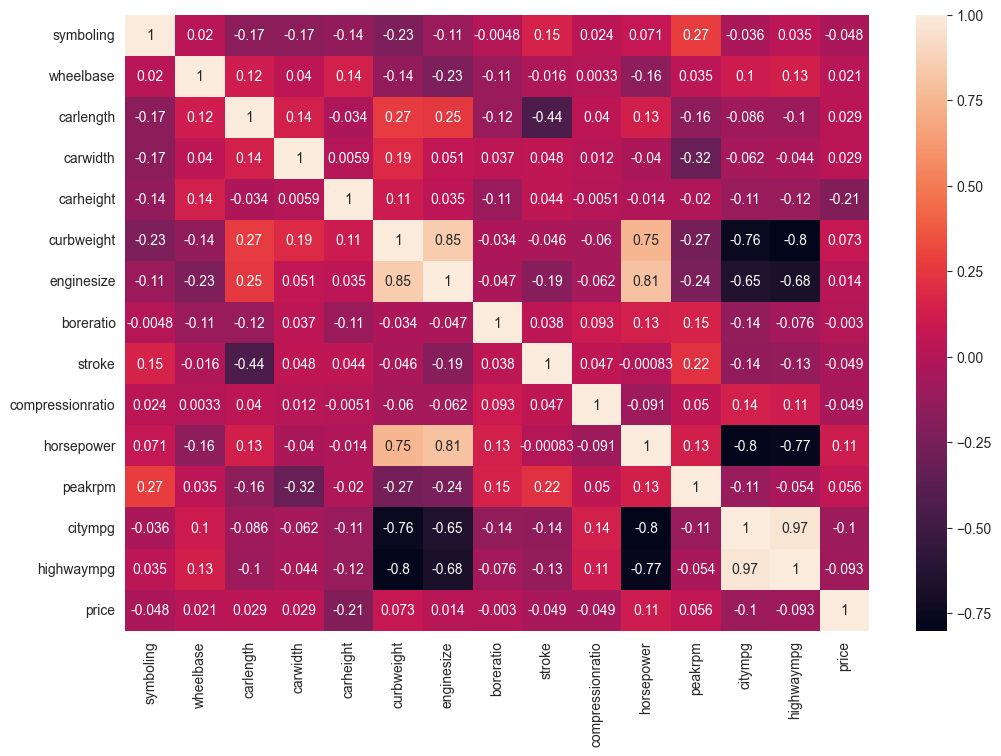

In [1549]:
plt.figure(figsize=(12, 8))

sns.heatmap(df_new[numerical_cols].corr(), annot=True)

plt.show()

Tìm ra các biến dạng số có sự tương quan lớn tới price => gần như không có độ tương quan rất thấp

In [1550]:
df_CarName_groupby = df_new.groupby(['CarName']).agg(
    total_cars = ('horsepower', 'count')
).sort_values(by='total_cars', ascending=False).reset_index()

df_CarName_groupby

,CarName,total_cars
0,peugeot 504,6
1,toyota corona,6
2,toyota corolla,6
3,subaru dl,4
4,toyota mark ii,3
...,...,...
142,honda prelude,1
143,honda civic 1500 gl,1
144,honda civic 1300,1
145,honda civic (auto),1


In [1551]:
# Xuất kết quả trên ra Excel để kiểm tra các CarName
# df_CarName_groupby.to_excel('CarName.xlsx')

In [1552]:
df_new['CarCompany'] = df_new['CarName'].apply(Split_Car_Name)

df_new

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,886.0,1688.0,...,mpfi,347.0,268.0,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,886.0,1688.0,...,mpfi,347.0,268.0,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,945.0,1712.0,...,mpfi,268.0,347.0,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,998.0,1766.0,...,mpfi,319.0,34.0,10.0,102,5500,24,30,13950.0,audi
4,2,audi 100ls,gas,std,four,sedan,4wd,front,994.0,1766.0,...,mpfi,319.0,34.0,8.0,115,5500,18,22,17450.0,audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,378.0,315.0,95.0,114,5400,23,28,16845.0,volvo
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,378.0,315.0,87.0,160,5300,19,25,19045.0,volvo
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,358.0,287.0,88.0,134,5500,18,23,21485.0,volvo
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,1091.0,1888.0,...,idi,301.0,34.0,23.0,106,4800,26,27,22470.0,volvo


In [1553]:
# Kiểm tra kết quả sau khi map lại dữ liệu CarCompany
df_new['CarCompany'].value_counts()

CarCompany
toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
peugeot        11
volvo          11
volkswagen      9
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
isuzu           4
porsche         4
alfa-romero     3
chevrolet       3
jaguar          3
vw              2
maxda           2
renault         2
toyouta         1
vokswagen       1
Nissan          1
mercury         1
porcshce        1
Name: count, dtype: int64

Ta sẽ thấy có 3 mã đáng ra phải là 1 đó là volkswagen, vw và vokswagen => ta sẽ gộp hết về volkswagen

toyota, toyouta => toyota

porsche, porcshce => porsche

mazda, maxda => mazda

nissan, Nissan => nissan

In [1554]:
df_new['CarCompany'] = df_new['CarCompany'].replace('vw', 'volkswagen').replace('vokswagen', 'volkswagen')
df_new['CarCompany'] = df_new['CarCompany'].replace('toyouta', 'toyota')
df_new['CarCompany'] = df_new['CarCompany'].replace('porcshce', 'porsche')
df_new['CarCompany'] = df_new['CarCompany'].replace('maxda', 'mazda')
df_new['CarCompany'] = df_new['CarCompany'].replace('Nissan', 'nissan')

df_new['CarCompany'].value_counts()

CarCompany
toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: count, dtype: int64

Map lại cột cylindernumber

In [1555]:
df_new['cylindernumber'] = df_new['cylindernumber'].apply(words_to_numbers)

df_new

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,886.0,1688.0,...,mpfi,347.0,268.0,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,886.0,1688.0,...,mpfi,347.0,268.0,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,945.0,1712.0,...,mpfi,268.0,347.0,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,998.0,1766.0,...,mpfi,319.0,34.0,10.0,102,5500,24,30,13950.0,audi
4,2,audi 100ls,gas,std,four,sedan,4wd,front,994.0,1766.0,...,mpfi,319.0,34.0,8.0,115,5500,18,22,17450.0,audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,378.0,315.0,95.0,114,5400,23,28,16845.0,volvo
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,378.0,315.0,87.0,160,5300,19,25,19045.0,volvo
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,1091.0,1888.0,...,mpfi,358.0,287.0,88.0,134,5500,18,23,21485.0,volvo
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,1091.0,1888.0,...,idi,301.0,34.0,23.0,106,4800,26,27,22470.0,volvo


In [1556]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    int64  
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

### 4.1. Xem xét về Price của các xe trong bảng dữ liệu

In [1557]:
print(f'Min Car Price = {df_new["price"].min()}')

Min Car Price = 5118.0


In [1558]:
print(f'Max Car Price = {df_new["price"].max()}')

Max Car Price = 17859167.0


In [1559]:
print(f'Mean Car Price = {df_new["price"].mean()}')

Mean Car Price = 102468.9512195122


In [1560]:
print(f'Median Car Price = {df_new["price"].median()}')

Median Car Price = 10595.0


In [1561]:
all_infomation_continuous_variable(df_new, 'price')

Các thông số thống kê cơ bản của price
count    2.050000e+02
mean     1.024690e+05
std      1.246484e+06
min      5.118000e+03
25%      7.788000e+03
50%      1.059500e+04
75%      1.655800e+04
max      1.785917e+07
Name: price, dtype: float64
price Median: 10595.0
price Mode: 0      5572.0
1      6229.0
2      6692.0
3      7295.0
4      7609.0
5      7775.0
6      7898.0
7      7957.0
8      8495.0
9      8845.0
10     8921.0
11     9279.0
12    13499.0
13    16500.0
14    18150.0
15    89165.0
Name: price, dtype: float64
price Q1: 7788.0
price Q3: 16558.0
price IQR: 8770.0
price Range: 17854049.0
price Var: 1553723335783.5476
price Std: 1246484.3905093828
price Skew: 14.310115796985
price Kurtosis: 204.85084648590842
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 18
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột price là 8.780487804878048


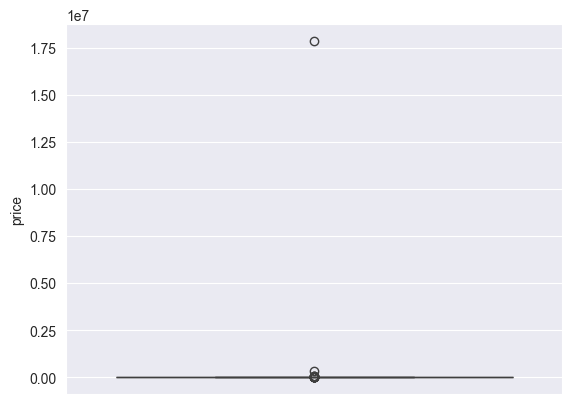

In [1562]:
# Khá khó nhìn vì có những outlier quá lớn => ta sẽ loại bỏ các outlier này
sns.boxplot(df_new['price'])

plt.show()

In [1563]:
df_new.sort_values(by='price', ascending=False).head(18)[['CarName', 'price']]

,CarName,price
9,audi 5000s (diesel),17859167.0
129,porsche cayenne,314005.0
44,isuzu D-Max,89165.0
45,isuzu D-Max V-Cross,89165.0
74,buick regal sport coupe (turbo),45400.0
16,bmw x5,41315.0
73,buick century special,40960.0
128,porsche boxter,37028.0
17,bmw x3,36880.0
49,jaguar xk,36000.0


In [1564]:
df_new.drop([129, 45, 44, 9], axis=0, inplace=True)

In [1565]:
df_new.sort_values(by='price', ascending=False)[['CarName', 'price']]

,CarName,price
74,buick regal sport coupe (turbo),45400.0
16,bmw x5,41315.0
73,buick century special,40960.0
128,porsche boxter,37028.0
17,bmw x3,36880.0
...,...,...
76,mitsubishi mirage,5389.0
150,toyota corona mark ii,5348.0
50,maxda rx3,5195.0
18,chevrolet impala,5151.0


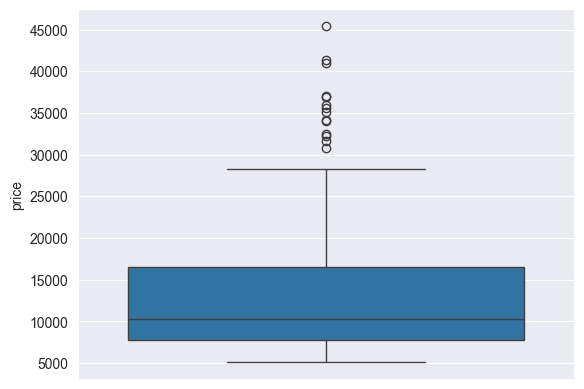

In [1566]:
# nhìn vào đây có thể thấy các xe có giá nằm trong khoảng từ 80k đến 170k
sns.boxplot(df_new['price'])

plt.show()

In [1567]:
# Vần còn outlier nhưng ít và không chênh lệch nhiều
all_infomation_continuous_variable(df_new, 'price')

Các thông số thống kê cơ bản của price
count      201.000000
mean     13207.129353
std       7947.066342
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16500.000000
max      45400.000000
Name: price, dtype: float64
price Median: 10295.0
price Mode: 0      5572.0
1      6229.0
2      6692.0
3      7295.0
4      7609.0
5      7775.0
6      7898.0
7      7957.0
8      8495.0
9      8845.0
10     8921.0
11     9279.0
12    13499.0
13    16500.0
14    18150.0
Name: price, dtype: float64
price Q1: 7775.0
price Q3: 16500.0
price IQR: 8725.0
price Range: 40282.0
price Var: 63155863.443184026
price Std: 7947.066341939271
price Skew: 1.8096753390980749
price Kurtosis: 3.2315368868295193
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 14
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột price là 6.965174129353234


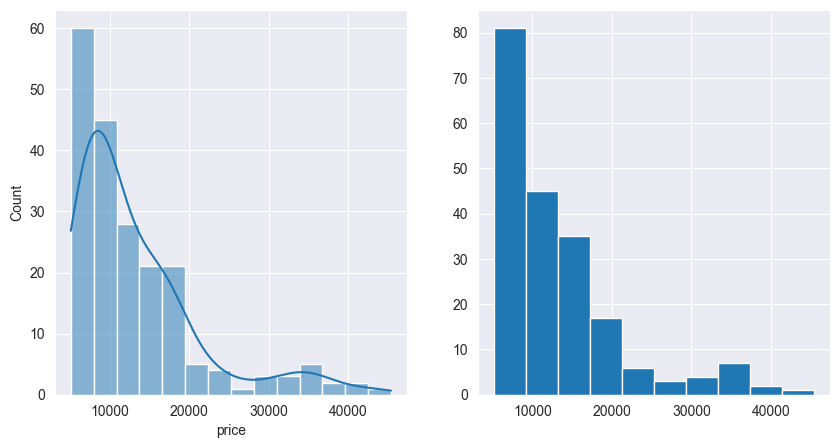

In [1568]:
# Nhìn vào biểu đồ thì có thể thấy các xe chủ yếu trong Database có mức giá dưới 180k => còn lại trên 180k có số lượng rất ít
hist_plot_continuous_variable(df_new, 'price')

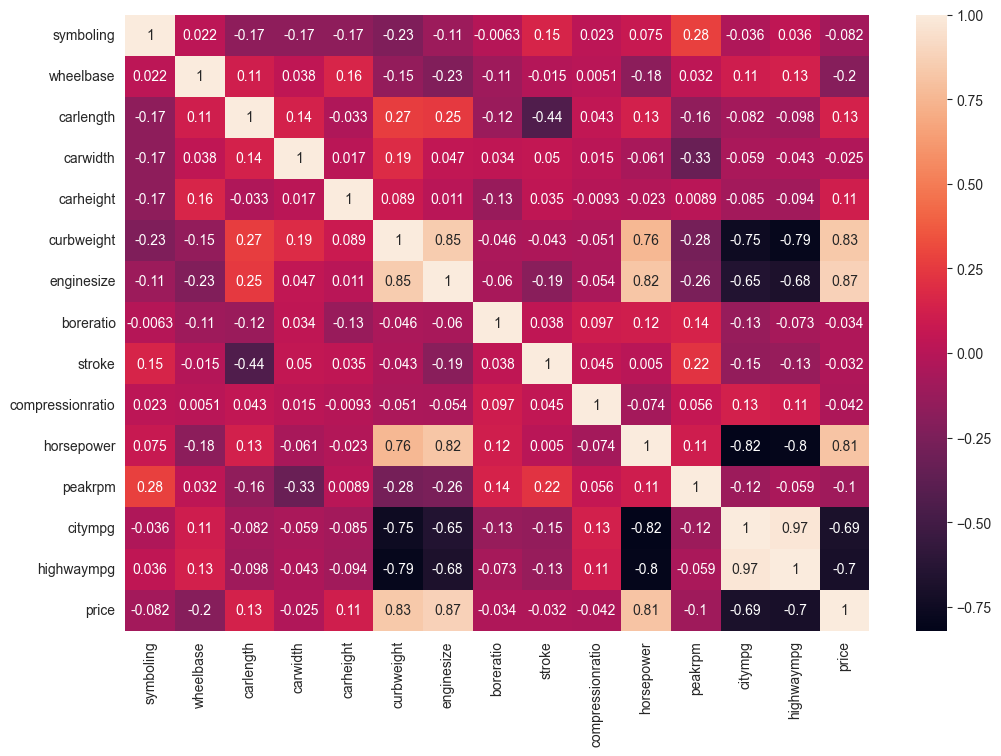

In [1569]:
plt.figure(figsize=(12, 8))

sns.heatmap(df_new[numerical_cols].corr(), annot=True)

plt.show()

### 4.2. Phân tích dữ liệu theo symboling

In [1570]:
df_new.groupby(['symboling']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='symboling', ascending=True).reset_index()

,symboling,mean_price,median_price,total_count
0,-2,15781.666667,15985.0,3
1,-1,17330.681818,16132.5,22
2,0,14397.092308,11259.0,65
3,1,9648.653846,7447.0,52
4,2,10109.281250,8995.0,32
5,3,17221.296296,14869.0,27


symboling đại diện cho xe có mức độ rủi ro thế nào. Xe có symboling thì rủi ro bảo hiểm càng thấp, còn lại càng cao thì rủi ro bảo hiểm càng cao => với những chiếc xe có symboling cao thì phí bảo hiểm cho các chiếc xe đó càng cao => mức giá để sở hữu các chiếc xe đó có thể sẽ cao lên

Tuy nhiên điều này không phải lúc nào cũng ảnh hưởng đến giá xe của chúng ta vì bạn có thể thấy các xe có độ rủi ro bảo hiểm cao thì mức giá trung bình của nó thậm chí còn cao hơn các xe có mức độ rủi ro bảo hiểm = 0

In [1571]:
df_new.groupby(['symboling']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='symboling', ascending=True).reset_index()

,symboling,mean_price,median_price,total_count
0,-2,15781.666667,15985.0,3
1,-1,17330.681818,16132.5,22
2,0,14397.092308,11259.0,65
3,1,9648.653846,7447.0,52
4,2,10109.281250,8995.0,32
5,3,17221.296296,14869.0,27


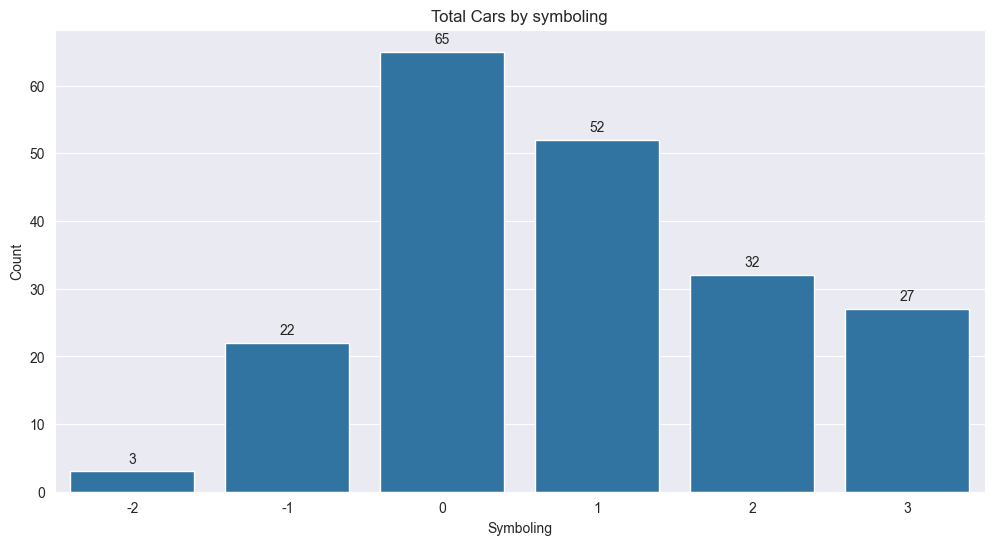

In [1572]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['symboling']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='symboling', ascending=True).reset_index(), x='symboling', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total Cars by symboling')
plt.xlabel('Symboling')
plt.ylabel('Count')

plt.show()

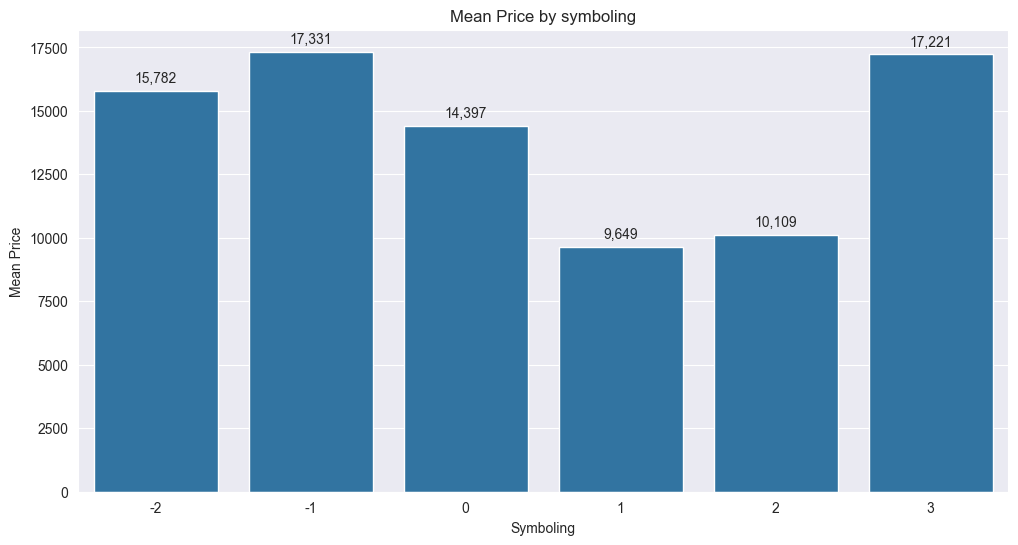

In [1573]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['symboling']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='symboling', ascending=True).reset_index(), x='symboling', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by symboling')
plt.xlabel('Symboling')
plt.ylabel('Mean Price')

plt.show()

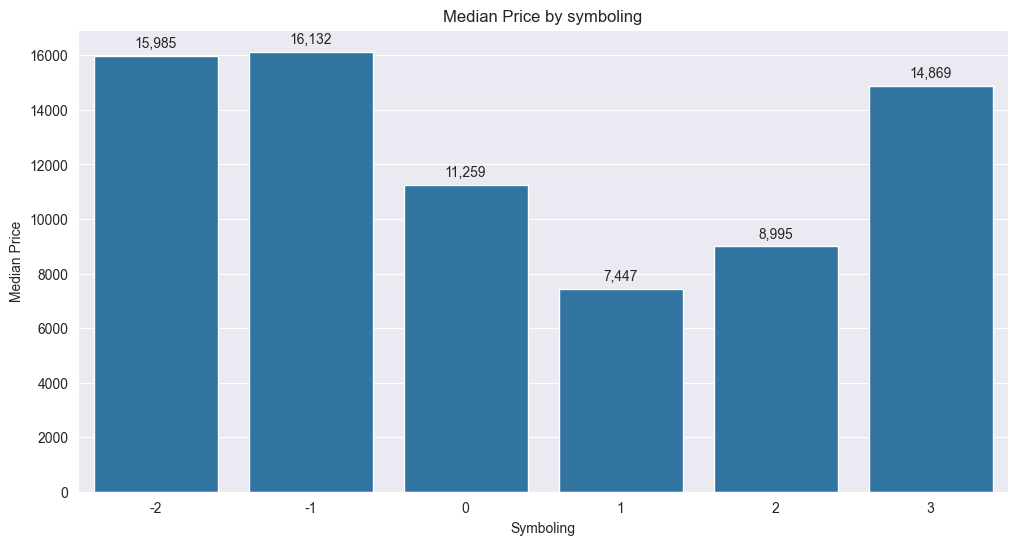

In [1574]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['symboling']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='symboling', ascending=True).reset_index(), x='symboling', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by symboling')
plt.xlabel('Symboling')
plt.ylabel('Median Price')

plt.show()

Symboling không ảnh hưởng nhiều đến giá của chiếc xe vì không có 1 quy luật nào ở đây cả. Ngoài ra hệ số tương quan của symboiling với price là -0.082 (Khá thấp)

### 4.3. Phân tích tình hình giá cả theo CarName

In [1575]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         201 non-null    int64  
 1   CarName           201 non-null    object 
 2   fueltype          201 non-null    object 
 3   aspiration        201 non-null    object 
 4   doornumber        201 non-null    object 
 5   carbody           201 non-null    object 
 6   drivewheel        201 non-null    object 
 7   enginelocation    201 non-null    object 
 8   wheelbase         201 non-null    float64
 9   carlength         201 non-null    float64
 10  carwidth          201 non-null    float64
 11  carheight         201 non-null    float64
 12  curbweight        201 non-null    int64  
 13  enginetype        201 non-null    object 
 14  cylindernumber    201 non-null    int64  
 15  enginesize        201 non-null    int64  
 16  fuelsystem        201 non-null    object 
 17  bo

In [1576]:
# < 100% => có nhiều xe cùng tên nhưng giá tiền lại khác nhau?
round(df_new['CarName'].nunique() / len(df_new) * 100, 2)

72.14

In [1577]:
df_new.groupby(['CarName', 'price']).agg(
    total_counts = ('CarCompany', 'count')
).sort_values(by='total_counts', ascending=False).reset_index()

,CarName,price,total_counts
0,Nissan versa,5499.0,1
1,subaru dl,7053.0,1
2,saab 99e,11850.0,1
3,saab 99e,18620.0,1
4,saab 99gle,15510.0,1
...,...,...,...
196,mazda rx-7 gs,13645.0,1
197,mazda rx-7 gs,18344.0,1
198,mazda rx2 coupe,6795.0,1
199,mercury cougar,16503.0,1


In [1578]:
df_car_name_groupby = df_new.groupby(['CarName']).agg(
    total_counts = ('price', 'count')
).sort_values(by='total_counts', ascending=False).reset_index()

df_car_name_groupby

,CarName,total_counts
0,peugeot 504,6
1,toyota corona,6
2,toyota corolla,6
3,subaru dl,4
4,toyota mark ii,3
...,...,...
140,honda prelude,1
141,honda civic 1500 gl,1
142,honda civic 1300,1
143,honda civic (auto),1


In [1579]:
# Lấy ra các tên xe xuất hiện nhiều lần
df_car_name_groupby[df_car_name_groupby['total_counts'] > 1]['CarName']

0                 peugeot 504
1               toyota corona
2              toyota corolla
3                   subaru dl
4              toyota mark ii
5                   mazda 626
6        mitsubishi mirage g4
7               mitsubishi g4
8        mitsubishi outlander
9                 honda civic
10               honda accord
11                  saab 99le
12    toyota corolla liftback
13        toyota corolla 1200
14              mazda rx-7 gs
15                 mazda rx-4
16           mazda glc deluxe
17           honda civic cvcc
18                   saab 99e
19                 saab 99gle
20                  mazda glc
21             toyota starlet
22                     subaru
23              peugeot 604sl
24                     bmw x3
25               nissan rogue
26                volvo 264gl
27          plymouth fury iii
28                 audi 100ls
29          volkswagen dasher
30                volvo 244dl
31                   bmw 320i
32               nissan latio
33        

In [1580]:
# điều này chứng tỏ là có cùng tên xe nhưng các chỉ số sẽ khác nhau
df_new[df_new['CarName'] == 'toyota corolla'][['CarName', 'curbweight', 'enginesize', 'horsepower', 'citympg', 'highwaympg', 'price']]

,CarName,curbweight,enginesize,horsepower,citympg,highwaympg,price
159,toyota corolla,2275,110,56,38,47,7788.0
161,toyota corolla,2122,98,70,28,34,8358.0
168,toyota corolla,2536,146,116,24,30,9639.0
171,toyota corolla,2714,146,116,24,30,11549.0
173,toyota corolla,2326,122,92,29,34,8948.0
176,toyota corolla,2414,122,92,27,32,10898.0


Tên xe không ảnh hưởng tới giá tiền của xe

### 4.4. Phân tích tình hình giá cả theo fueltype

In [1581]:
df_new.groupby(['fueltype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='fueltype', ascending=True).reset_index()

# Chỉ có 2 loại là sử dụng dầu diesel và gas

,fueltype,mean_price,median_price,total_count
0,diesel,15838.15000,13852.5,20
1,gas,12916.40884,9989.0,181


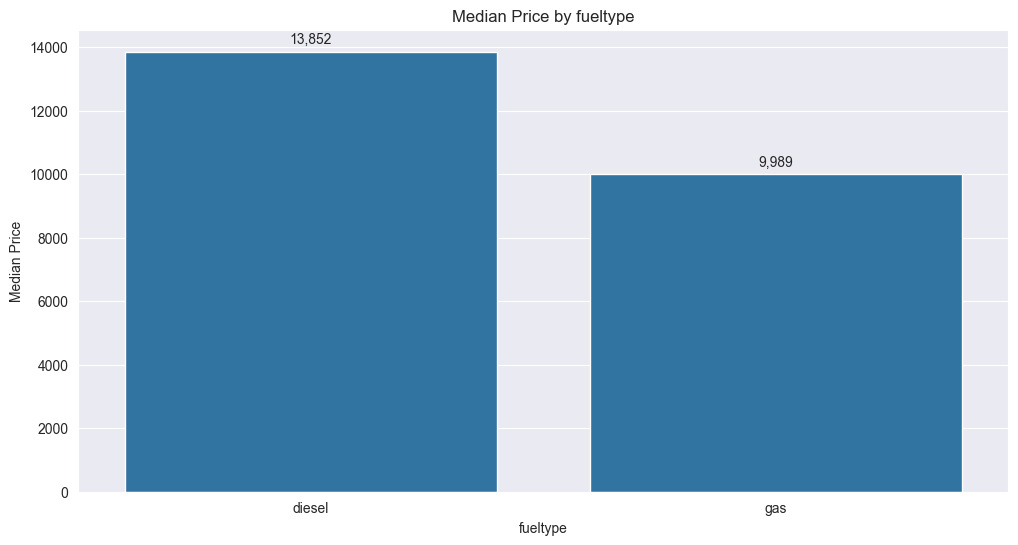

In [1582]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fueltype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='fueltype', ascending=True).reset_index(), x='fueltype', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by fueltype')
plt.xlabel('fueltype')
plt.ylabel('Median Price')

plt.show()

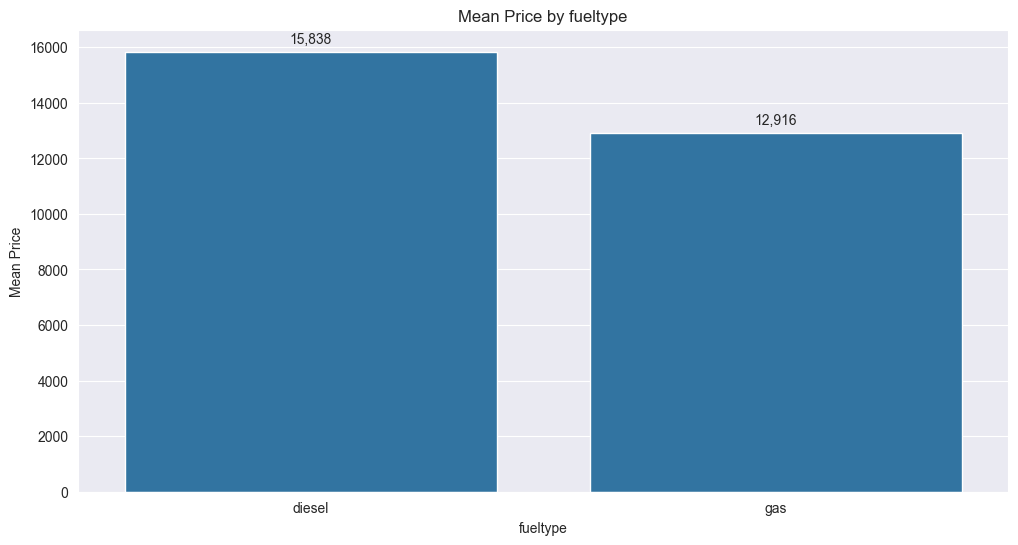

In [1583]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fueltype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='fueltype', ascending=True).reset_index(), x='fueltype', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by fueltype')
plt.xlabel('fueltype')
plt.ylabel('Mean Price')

plt.show()

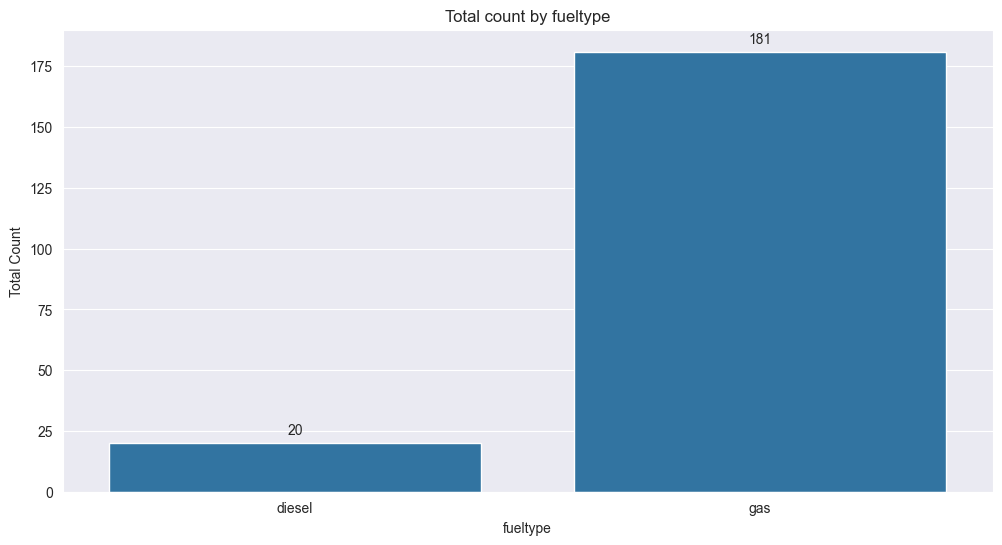

In [1584]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fueltype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='fueltype', ascending=True).reset_index(), x='fueltype', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by fueltype')
plt.xlabel('fueltype')
plt.ylabel('Total Count')

plt.show()

Các sản phẩm chạy bằng dầu diesel ít hơn nhiều so với chạy bằng gas tuy nhiên giá xe chạy bằng dầu diesel có giá cao hơn so với xe chạy bằng gas.

Trong thực tế thì các xe chạy dầu diesel luôn có giá cao hơn xăng vì Do các chi tiết của hệ thống nhiên liệu như kim phun, bơm cao áp có thiết kế rất tinh vi và đòi hỏi độ xác thực rất cao nên việc tu tạo phải được thực hiện bởi những máy móc tiên tiến, đắt tiền và tiến hành bởi thợ tay nghề cao nên giá thành sửa chữa cao => Đây là lý do chính khiến xe chạy dầu Diesel đắt hơn xe xăng

Điều này chứng tỏ việc xe chạy dầu diesel hay xăng có ảnh hưởng đến giá xe

### 4.5. Phân tích tình hình giá cả theo aspiration (Loại tăng áp sử dụng trong xe)

In [1585]:
df_new['aspiration'].value_counts()

aspiration
std      165
turbo     36
Name: count, dtype: int64

- <b>STD (naturally aspirated / động cơ thông thường)</b>: Đây là loại động cơ không có hệ thống tăng áp (turbocharger hoặc supercharger). Thay vào đó, động cơ này hoạt động dựa trên nguyên lý hút khí tự nhiên thông qua quá trình hút không khí vào và đốt cháy nó trong xi lanh. Động cơ STD thường có kích thước nhỏ hơn và không có hiệu suất tăng cường so với các động cơ tăng áp.
- <b>Turbo (turbocharged / động cơ tăng áp)</b>: Đây là loại động cơ có hệ thống tăng áp, trong đó khí nạp vào động cơ được nén trước khi đốt cháy. Hệ thống tăng áp giúp tăng hiệu suất của động cơ bằng cách cung cấp lượng khí nạp nhiều hơn vào xi lanh so với động cơ thông thường. Kết quả là, động cơ turbo thường có hiệu suất cao hơn và cung cấp một lượng lớn công suất tăng khi cần thiết.

Thường thì các xe ô tô được trang bị động cơ turbo sẽ có giá cao hơn so với các xe có động cơ thông thường (STD). Lý do chính là các động cơ turbo thường có hiệu suất cao hơn, cung cấp công suất tốt hơn và tiết kiệm nhiên liệu hơn so với các động cơ thông thường. => chỉ tiêu aspiration có ảnh hưởng đến giá xe

In [1586]:
df_new.groupby(['aspiration']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='aspiration', ascending=True).reset_index()

,aspiration,mean_price,median_price,total_count
0,std,12542.181818,9538.0,165
1,turbo,16254.805556,15686.0,36


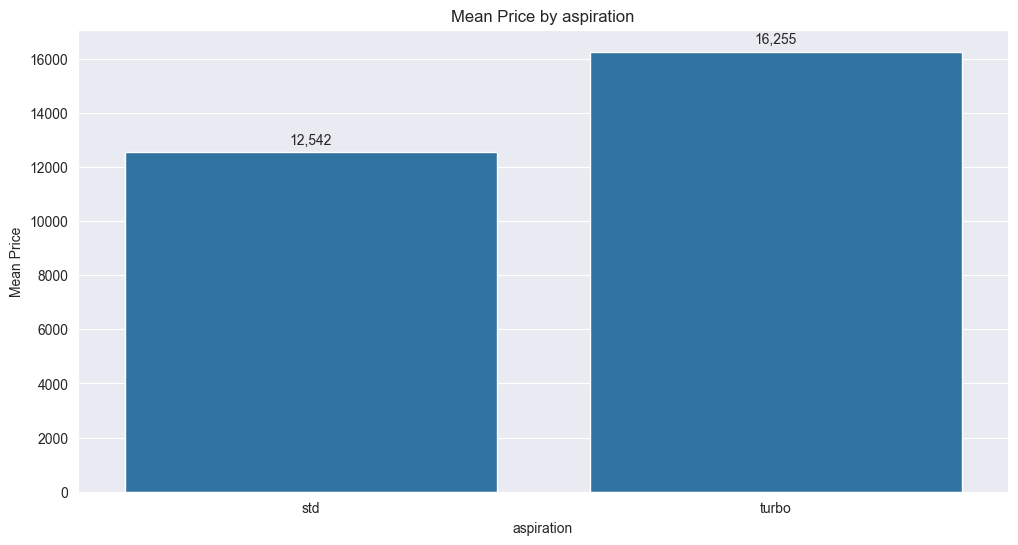

In [1587]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['aspiration']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='aspiration', ascending=True).reset_index(), x='aspiration', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by aspiration')
plt.xlabel('aspiration')
plt.ylabel('Mean Price')

plt.show()

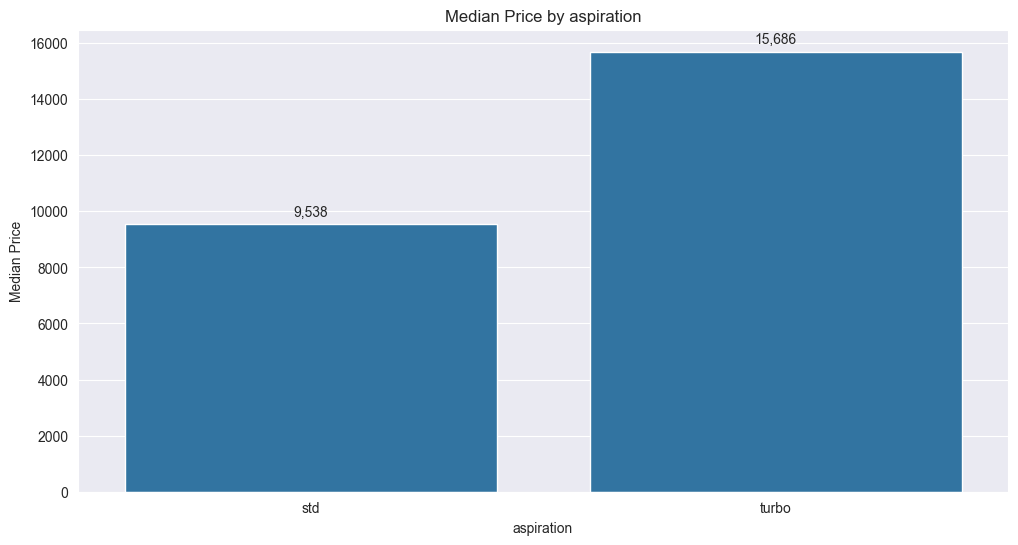

In [1588]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['aspiration']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='aspiration', ascending=True).reset_index(), x='aspiration', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by aspiration')
plt.xlabel('aspiration')
plt.ylabel('Median Price')

plt.show()

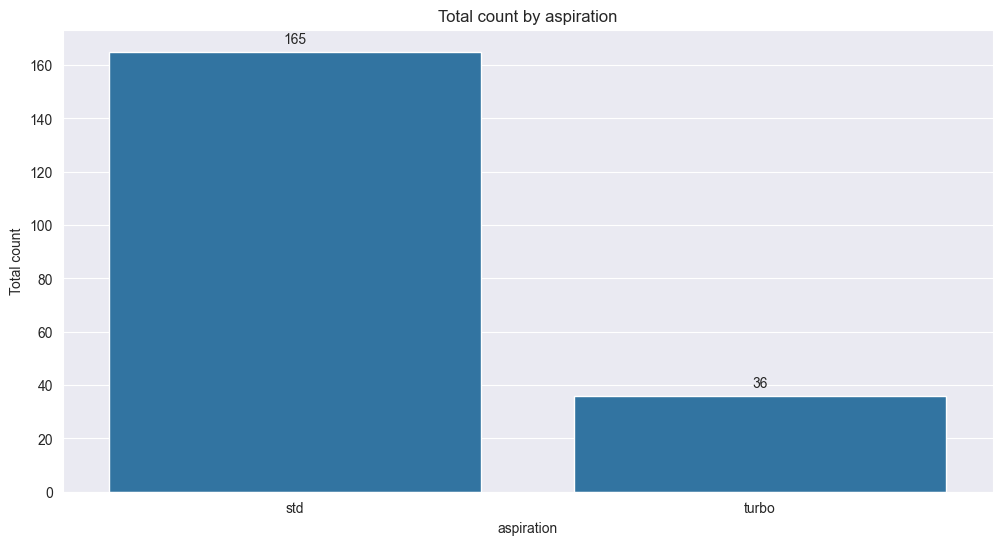

In [1589]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['aspiration']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='aspiration', ascending=True).reset_index(), x='aspiration', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by aspiration')
plt.xlabel('aspiration')
plt.ylabel('Total count')

plt.show()

Thực tế dữ liệu cũng chứng minh xe dùng động cơ turbo có giá cao hơn so với xe dùng động cơ thông thường. Việc sử dụng các động cơ khác nhau cũng có ảnh hưởng đến giá xe

### 4.6. Phân tích tình hình giá cả theo doornumber (Số lượng cửa của xe)

In [1590]:
# Số xe 2 cửa và 4 cửa có số lượng khá tương đương nhau
df_new['doornumber'].value_counts()

doornumber
four    114
two      87
Name: count, dtype: int64

In [1591]:
# xe có 4 cửa có giá trung bình cao hơn các loại xe có 2 cửa
df_new.groupby(['doornumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='doornumber', ascending=True).reset_index()

,doornumber,mean_price,median_price,total_count
0,four,13541.368421,11071.5,114
1,two,12769.160920,9895.0,87


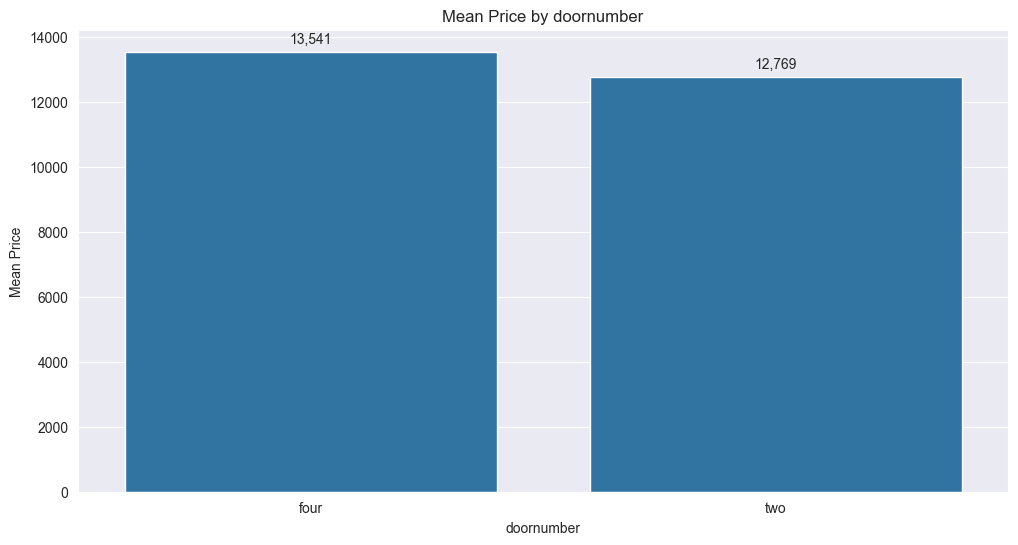

In [1592]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['doornumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='doornumber', ascending=True).reset_index(), x='doornumber', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by doornumber')
plt.xlabel('doornumber')
plt.ylabel('Mean Price')

plt.show()

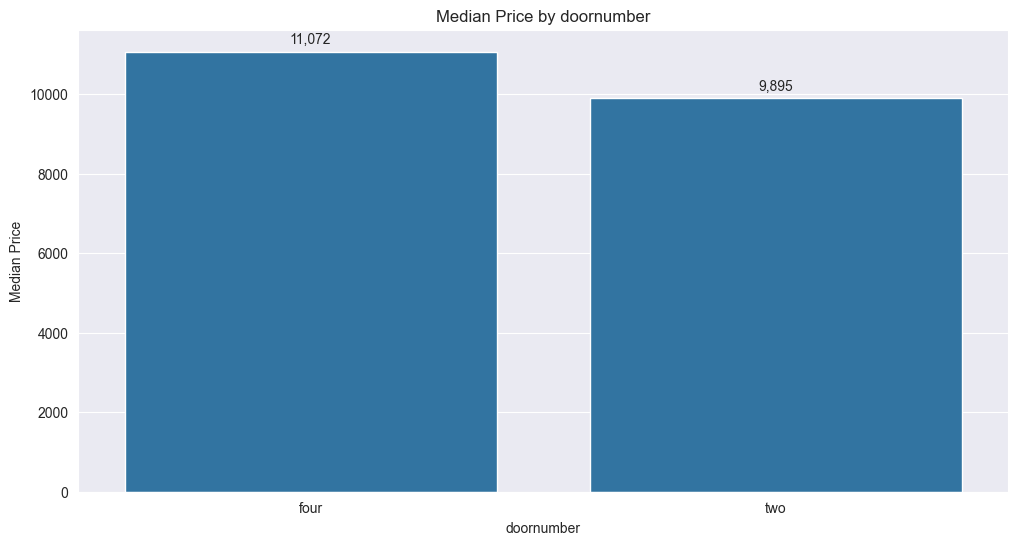

In [1593]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['doornumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='doornumber', ascending=True).reset_index(), x='doornumber', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by doornumber')
plt.xlabel('doornumber')
plt.ylabel('Median Price')

plt.show()

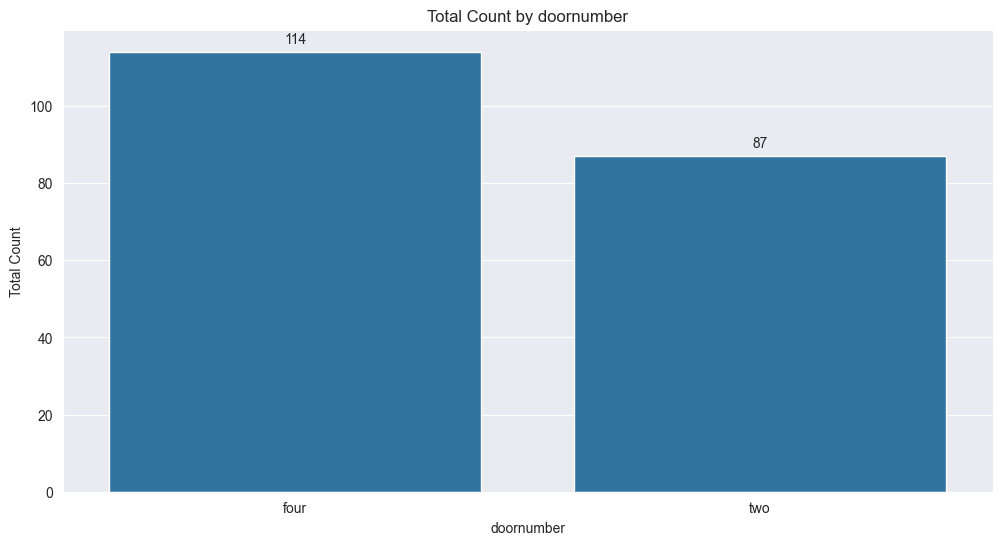

In [1594]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['doornumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='doornumber', ascending=True).reset_index(), x='doornumber', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total Count by doornumber')
plt.xlabel('doornumber')
plt.ylabel('Total Count')

plt.show()

Mức giá của xe loại 2 cửa và 4 cửa thực sự không chênh lệch nhau nhiều.

Trong thực tế đa phần các xe có 4 cửa sẽ có mức giá cao hơn so với xe 2 cửa.

Tuy nhiên 1 số mẫu xe thể thao chỉ có 2 cửa lại có giá cao hơn rất nhiều. Vì vậy giá xe sẽ không chịu ảnh hưởng bởi số lượng cửa của nó

### 4.7. Phân tích tình hình giá cả theo carbody (Thân xe)

In [1595]:
df_new['carbody'].value_counts()

carbody
sedan          94
hatchback      68
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64

In [1596]:
# xe có 4 cửa có giá trung bình cao hơn các loại xe có 2 cửa
df_new.groupby(['carbody']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

,carbody,mean_price,median_price,total_count
0,hardtop,22208.500000,19687.5,8
1,convertible,21890.500000,17084.5,6
2,sedan,14459.755319,11078.5,94
3,wagon,12371.960000,11694.0,25
4,hatchback,9957.441176,8672.0,68


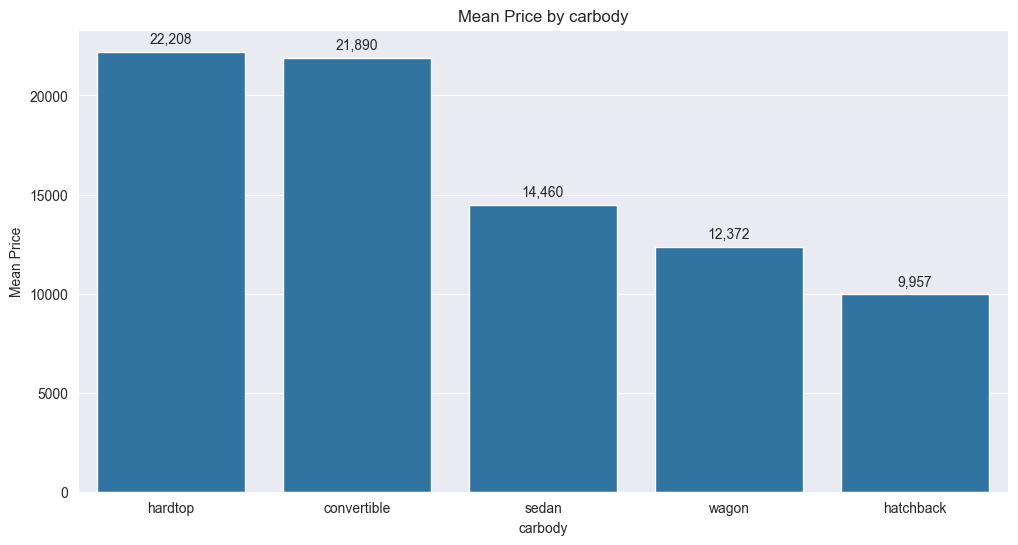

In [1597]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['carbody']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='carbody', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by carbody')
plt.xlabel('carbody')
plt.ylabel('Mean Price')

plt.show()

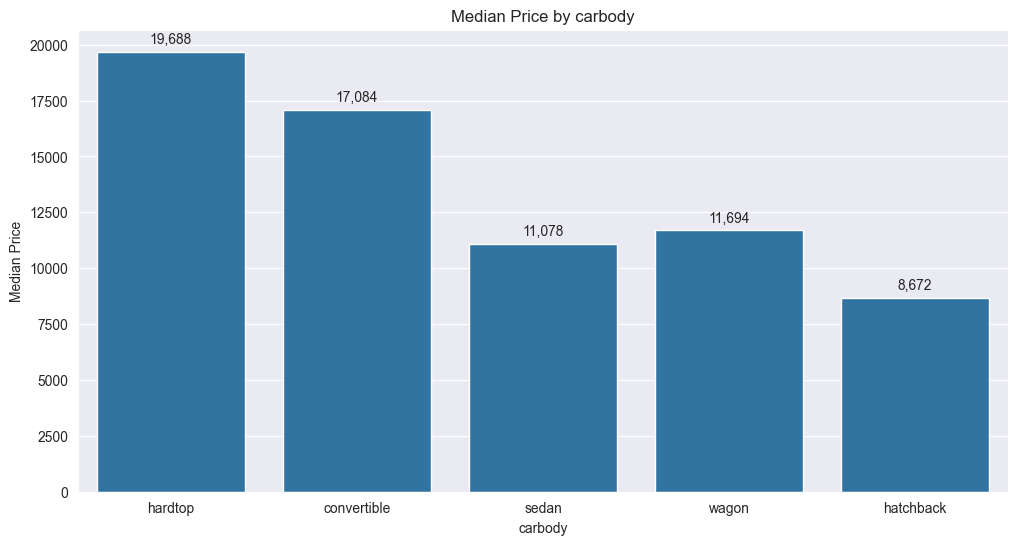

In [1598]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['carbody']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='carbody', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by carbody')
plt.xlabel('carbody')
plt.ylabel('Median Price')

plt.show()

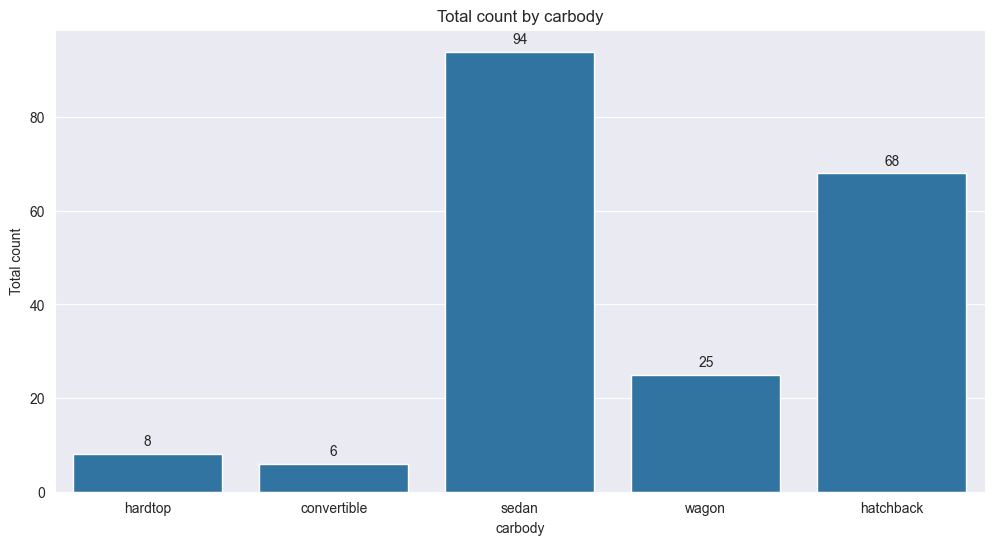

In [1599]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['carbody']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='carbody', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by carbody')
plt.xlabel('carbody')
plt.ylabel('Total count')

plt.show()

Nhìn vào đây ta có thể thấy rõ giá trung bình của xe ô tô có xu hướng giảm dần theo carbody => điều này chứng tỏ thân xe khác nhau sẽ có mức giá khác nhau => có ảnh hưởng đến giá trị của xe.

### 4.8. Phân tích tình hình giá cả theo drivewheel (Bánh lái)

In [1600]:
df_new['drivewheel'].value_counts()

drivewheel
fwd    118
rwd     75
4wd      8
Name: count, dtype: int64

In [1601]:
df_new['drivewheel'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

- <b>RWD (Rear-Wheel Drive)</b>: Trong hệ thống này, bánh lái được động bởi bánh sau của xe. Điều này có nghĩa là động cơ truyền động chỉ đẩy lực đến bánh sau của xe. RWD thường được sử dụng trong các xe thể thao và xe hạng sang, vì nó cung cấp trải nghiệm lái xe truyền cảm giác và tốt cho việc vận hành với tốc độ cao.
- <b>FWD (Front-Wheel Drive)</b>: Trong hệ thống này, bánh lái được động bởi bánh trước của xe. Điều này có nghĩa là động cơ truyền động tạo lực kéo từ phía trước của xe. FWD thường được sử dụng trong các xe hạng trung và xe du lịch, vì nó cung cấp sự tiết kiệm nhiên liệu và dễ điều khiển hơn trong điều kiện đường trơn trượt.
- <b>4WD (Four-Wheel Drive)</b>: Trong hệ thống này, cả bánh trước và bánh sau đều được động. Thường thì xe 4WD có thể chuyển đổi giữa chế độ lái 4 bánh hoặc chỉ 2 bánh. 4WD thường được sử dụng trong các xe off-road và các xe đa dụng có khả năng vận hành tốt trên mọi loại địa hình.

đọc qua các thông tin này thì có thể thấy giá cả của xe có liên quan tới bánh lái của xe được sử dụng là loại nào. Ta sẽ chứng minh nó bằng dữ liệu

In [1602]:
# xe có 4 cửa có giá trung bình cao hơn các loại xe có 2 cửa
df_new.groupby(['drivewheel']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

# Theo dữ liệu thu thập được thì giá của xe sử dụng RWD sẽ có giá cao hơn so với 4WD và FWD => Ta sẽ chứng minh nó bằng dữ liệu

,drivewheel,mean_price,median_price,total_count
0,rwd,19757.613333,16900.0,75
1,4wd,10241.000000,9005.5,8
2,fwd,9244.779661,8192.0,118


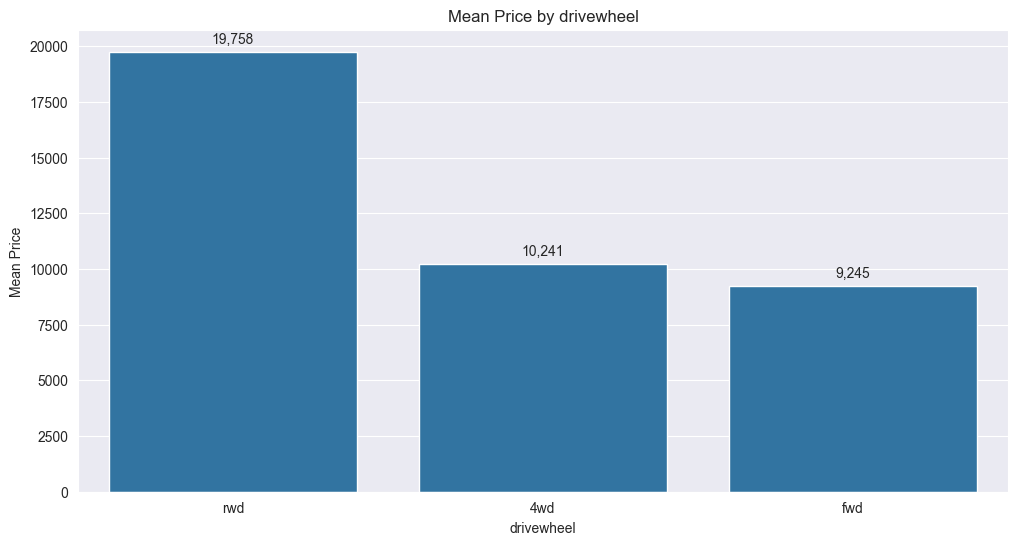

In [1603]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['drivewheel']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='drivewheel', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by drivewheel')
plt.xlabel('drivewheel')
plt.ylabel('Mean Price')

plt.show()

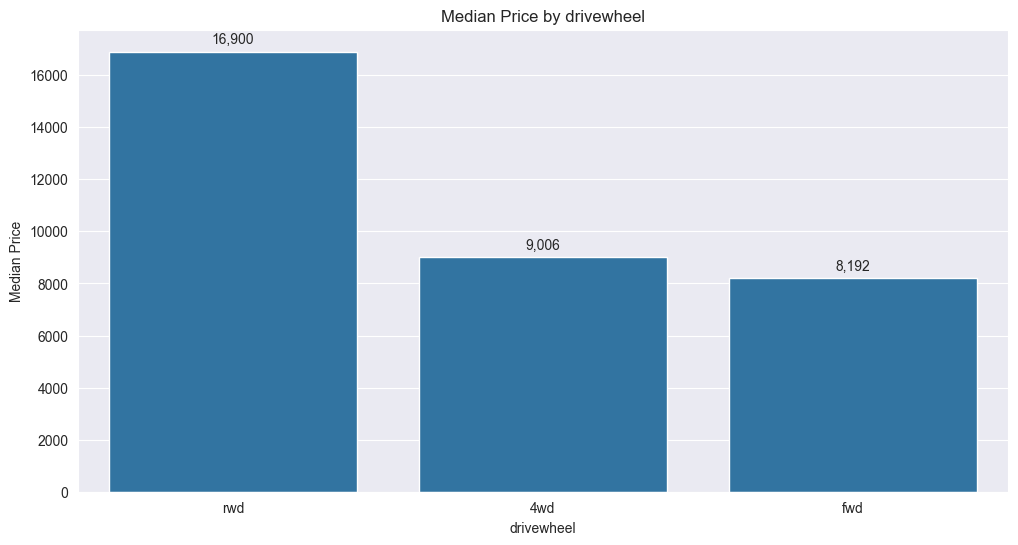

In [1604]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['drivewheel']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='drivewheel', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by drivewheel')
plt.xlabel('drivewheel')
plt.ylabel('Median Price')

plt.show()

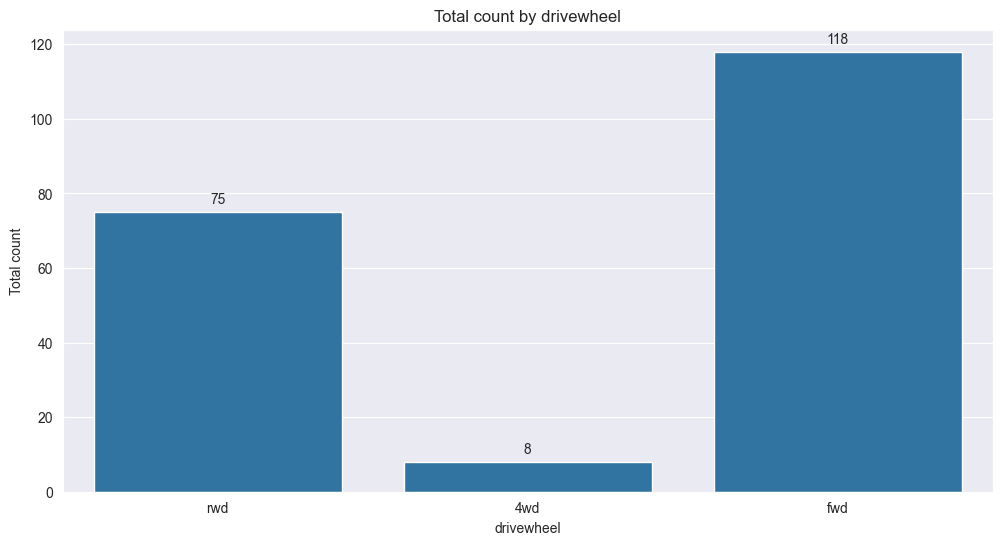

In [1605]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['drivewheel']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='drivewheel', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by drivewheel')
plt.xlabel('drivewheel')
plt.ylabel('Total count')

plt.show()

Bạn có thể thấy rõ sự phân hoá của mức giá theo bánh lái. Các xe sử dụng RWD có giá cao nhất, sau đó mới tới 4WD và FWD. Điều này cũng dễ hiểu vì RWD được sử dụng trên các mẫu xe thể thao hoặc hạng sang nên có giá trị rất lớn

### 4.9. Phân tích tình hình giá cả theo enginelocation (Vị trí động cơ xe)

In [1606]:
df_new['enginelocation'].unique()

array(['front', 'rear'], dtype=object)

In [1607]:
df_new['enginelocation'].value_counts()

enginelocation
front    198
rear       3
Name: count, dtype: int64

Chủ yếu là front, dữ liệu rear khá ít nên ta sẽ bỏ feature này

### 4.10. Phân tích tình hình giá cả theo wheelbase (khoảng cách giữa trục bánh xe trước và trục bánh xe sau của xe)

In [1608]:
all_infomation_continuous_variable(df_new, 'wheelbase')

Các thông số thống kê cơ bản của wheelbase
count     201.000000
mean      922.820896
std       231.459236
min        93.000000
25%       943.000000
50%       963.000000
75%      1004.000000
max      1209.000000
Name: wheelbase, dtype: float64
wheelbase Median: 963.0
wheelbase Mode: 0    937.0
Name: wheelbase, dtype: float64
wheelbase Q1: 943.0
wheelbase Q3: 1004.0
wheelbase IQR: 61.0
wheelbase Range: 1116.0
wheelbase Var: 53573.37776119415
wheelbase Std: 231.45923563598438
wheelbase Skew: -3.0513604718073895
wheelbase Kurtosis: 8.3256765676687
Phân phối lệch trái
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 7
Số lượng Outlier bên dưới là: 14
Phần trăm Outlier của cột wheelbase là 10.44776119402985


số lượng outlier không quá nhiều (6.95%) và không làm ảnh hưởng nhiều đến kết quả khi mean và median khá gần nhau nên ta sẽ không loại bỏ Outlier trong trường hợp này

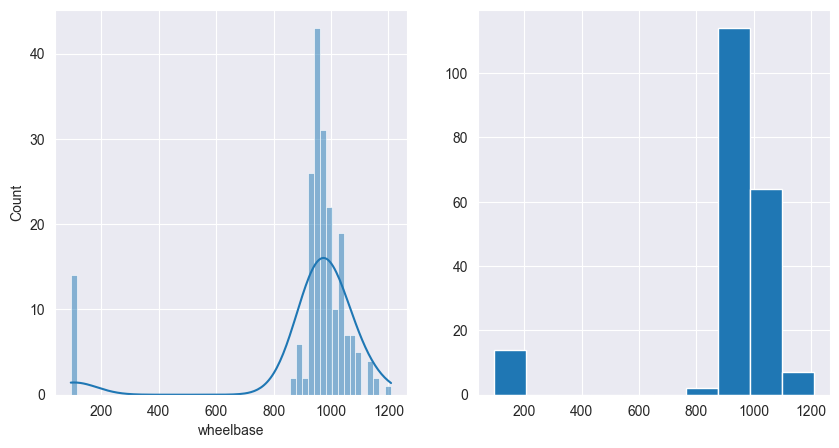

In [1609]:
hist_plot_continuous_variable(df_new, 'wheelbase')

Thực tế là wheelbase có ảnh hưởng đến giá của chiếc xe vì nó liên quan đến không gian bên trong của xe, sự thoải mái và tiện nghi cho hành khách và hàng hoá => có liên quan đến giá xe

In [1610]:
# Lấy ra 1 số chiếc xe có wheelbase < 200 => nhưng bạn có thể thấy giá của các chiếc xe này cũng không hề rẻ => giá xe còn phụ thuộc nhiều yếu tố chứ wheelbase ko quyết định tất cả
df_new[df_new['wheelbase'] < 200]

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
17,0,bmw x3,gas,std,four,sedan,rwd,front,110.0,197.0,...,mpfi,362.0,339.0,8.0,182,5400,15,20,36880.0,bmw
46,2,isuzu D-Max,gas,std,two,hatchback,rwd,front,96.0,1726.0,...,spfi,343.0,323.0,92.0,90,5000,24,29,11048.0,isuzu
47,0,jaguar xj,gas,std,four,sedan,rwd,front,113.0,1996.0,...,mpfi,363.0,417.0,81.0,176,4750,15,19,32250.0,jaguar
48,0,jaguar xf,gas,std,four,sedan,rwd,front,113.0,1996.0,...,mpfi,363.0,417.0,81.0,176,4750,15,19,35550.0,jaguar
49,0,jaguar xk,gas,std,two,sedan,rwd,front,102.0,1917.0,...,mpfi,354.0,276.0,115.0,262,5000,13,17,36000.0,jaguar
67,-1,buick electra 225 custom,diesel,turbo,four,sedan,rwd,front,110.0,1909.0,...,idi,358.0,364.0,215.0,123,4350,22,25,25552.0,buick
68,-1,buick century luxus (sw),diesel,turbo,four,wagon,rwd,front,110.0,1909.0,...,idi,358.0,364.0,215.0,123,4350,22,25,28248.0,buick
74,1,buick regal sport coupe (turbo),gas,std,two,hardtop,rwd,front,112.0,1992.0,...,mpfi,38.0,335.0,8.0,184,4500,14,16,45400.0,buick
79,1,mitsubishi g4,gas,turbo,two,hatchback,fwd,front,93.0,1573.0,...,spdi,303.0,339.0,76.0,102,5500,24,30,7689.0,mitsubishi
117,0,peugeot 604sl,gas,turbo,four,sedan,rwd,front,108.0,1867.0,...,mpfi,361.0,321.0,7.0,142,5600,18,24,18150.0,peugeot


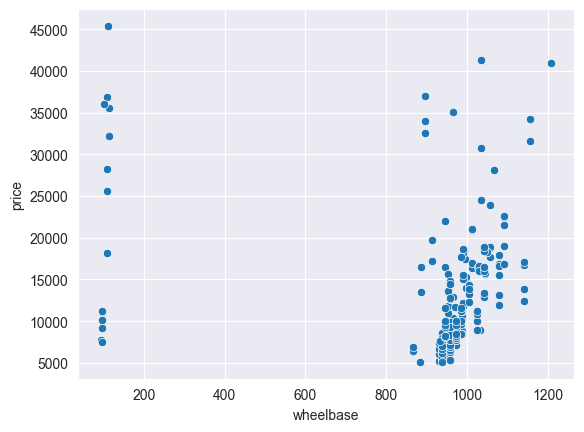

In [1611]:
sns.scatterplot(df_new, x='wheelbase', y='price')

plt.show()

Ta có thể thấy ở đây wheelbase cao không có nghĩa là giá xe sẽ cao => ta sẽ loại bỏ feature này khi xây dựng model

### 4.11. Phân tích tình hình giá cả theo carlength (chiều dài xe)

In [1612]:
all_infomation_continuous_variable(df_new, 'carlength')

Các thông số thống kê cơ bản của carlength
count     201.000000
mean     1596.174129
std       476.170310
min       150.000000
25%      1634.000000
50%      1724.000000
75%      1815.000000
max      2081.000000
Name: carlength, dtype: float64
carlength Median: 1724.0
carlength Mode: 0    1573.0
Name: carlength, dtype: float64
carlength Q1: 1634.0
carlength Q3: 1815.0
carlength IQR: 181.0
carlength Range: 1931.0
carlength Var: 226738.16452736317
carlength Std: 476.1703104219783
carlength Skew: -2.4827980867063504
carlength Kurtosis: 4.8648733890128835
Phân phối lệch trái
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 0
Số lượng Outlier bên dưới là: 19
Phần trăm Outlier của cột carlength là 9.45273631840796


số lượng outlier không quá nhiều (9%) và không làm ảnh hưởng nhiều đến kết quả khi mean và median khá gần nhau nên ta sẽ không loại bỏ Outlier trong trường hợp này

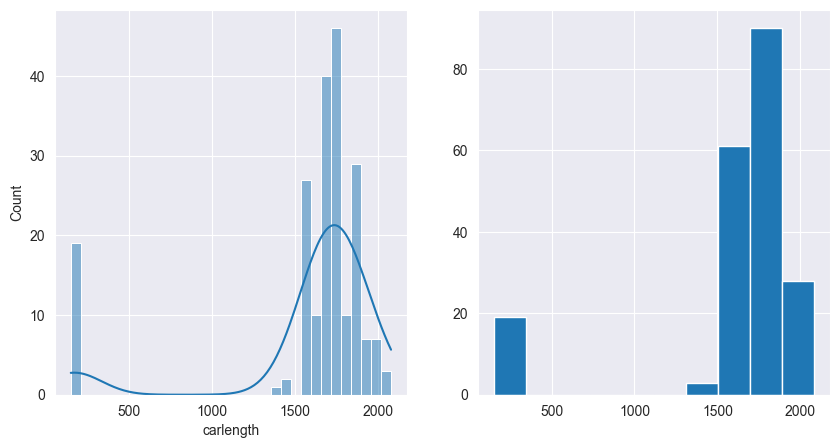

In [1613]:
hist_plot_continuous_variable(df_new, 'carlength')

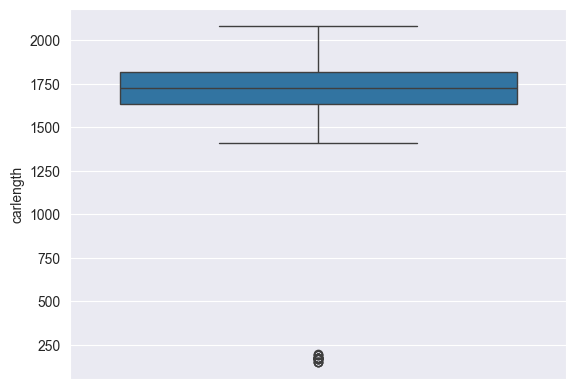

In [1614]:
sns.boxplot(df_new['carlength'])

plt.show()

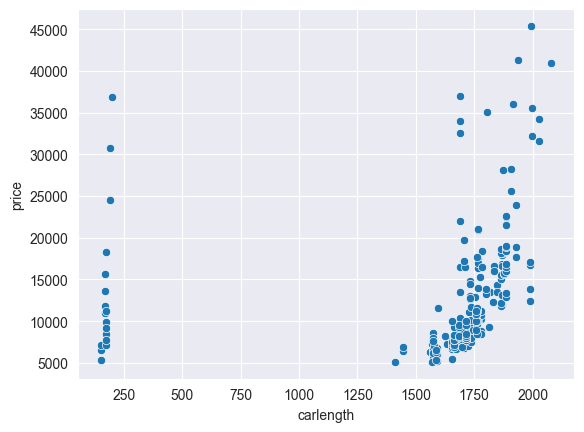

In [1615]:
sns.scatterplot(df_new, x='carlength', y='price')

plt.show()

xe dài cũng không có nghĩa là giá cao => loại bỏ yếu tố này khi xây dựng model

### 4.12. Phân tích tình hình giá cả theo carwidth (chiều rộng xe)

In [1616]:
all_infomation_continuous_variable(df_new, 'carwidth')

Các thông số thống kê cơ bản của carwidth
count    201.000000
mean     615.144279
std      157.865684
min       64.000000
25%      638.000000
50%      654.000000
75%      665.000000
max      717.000000
Name: carwidth, dtype: float64
carwidth Median: 654.0
carwidth Mode: 0    638.0
Name: carwidth, dtype: float64
carwidth Q1: 638.0
carwidth Q3: 665.0
carwidth IQR: 27.0
carwidth Range: 653.0
carwidth Var: 24921.57407960198
carwidth Std: 157.8656836668501
carwidth Skew: -3.1676086421843337
carwidth Kurtosis: 8.359664358078966
Phân phối lệch trái
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 8
Số lượng Outlier bên dưới là: 15
Phần trăm Outlier của cột carwidth là 11.442786069651742


số lượng outlier không quá nhiều (7.49%) và không làm ảnh hưởng nhiều đến kết quả khi mean và median khá gần nhau nên ta sẽ không loại bỏ Outlier trong trường hợp này

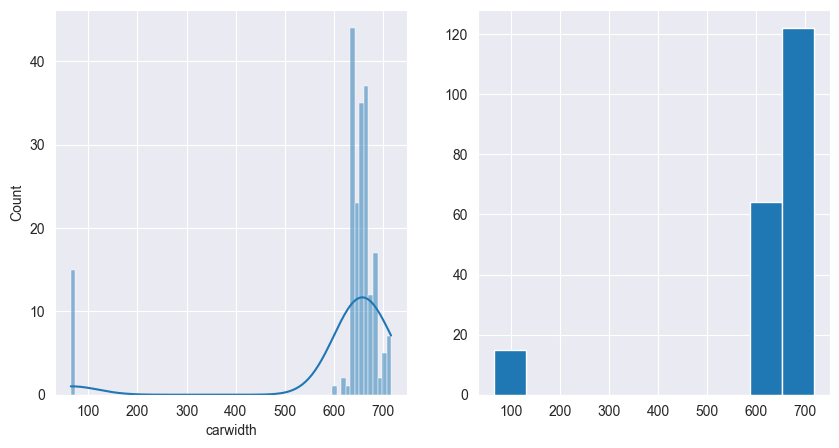

In [1617]:
hist_plot_continuous_variable(df_new, 'carwidth')

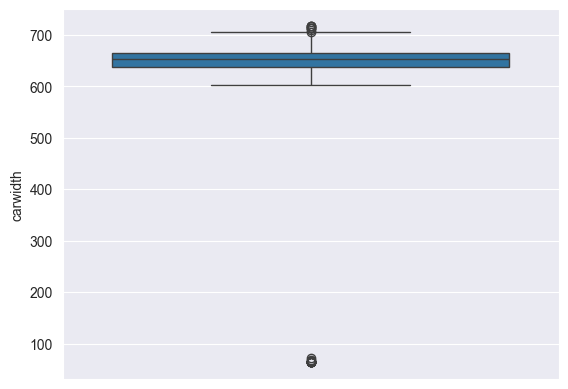

In [1618]:
sns.boxplot(df_new['carwidth'])

plt.show()

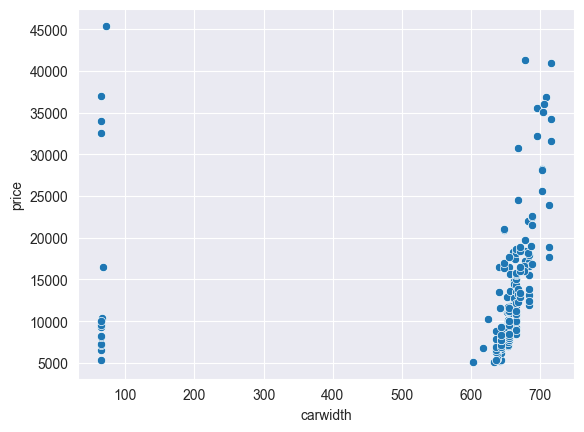

In [1619]:
sns.scatterplot(df_new, x='carwidth', y='price')

plt.show()

Xe rộng không có nghĩa là giá cao => loại bỏ yếu tố này khi xây dựng model

### 4.13. Phân tích tình hình giá cả theo carheight (chiều cao xe)

In [1620]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         201 non-null    int64  
 1   CarName           201 non-null    object 
 2   fueltype          201 non-null    object 
 3   aspiration        201 non-null    object 
 4   doornumber        201 non-null    object 
 5   carbody           201 non-null    object 
 6   drivewheel        201 non-null    object 
 7   enginelocation    201 non-null    object 
 8   wheelbase         201 non-null    float64
 9   carlength         201 non-null    float64
 10  carwidth          201 non-null    float64
 11  carheight         201 non-null    float64
 12  curbweight        201 non-null    int64  
 13  enginetype        201 non-null    object 
 14  cylindernumber    201 non-null    int64  
 15  enginesize        201 non-null    int64  
 16  fuelsystem        201 non-null    object 
 17  bo

In [1621]:
all_infomation_continuous_variable(df_new, 'carheight')

Các thông số thống kê cơ bản của carheight
count    201.000000
mean     497.681592
std      137.752634
min       51.000000
25%      508.000000
50%      541.000000
75%      555.000000
max      598.000000
Name: carheight, dtype: float64
carheight Median: 541.0
carheight Mode: 0    508.0
Name: carheight, dtype: float64
carheight Q1: 508.0
carheight Q3: 555.0
carheight IQR: 47.0
carheight Range: 547.0
carheight Var: 18975.788109452733
carheight Std: 137.75263376593833
carheight Skew: -2.8456017979619723
carheight Kurtosis: 6.532775545602481
Phân phối lệch trái
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 0
Số lượng Outlier bên dưới là: 17
Phần trăm Outlier của cột carheight là 8.45771144278607


số lượng outlier không quá nhiều (9.09%) và không làm ảnh hưởng nhiều đến kết quả khi mean và median khá gần nhau nên ta sẽ không loại bỏ Outlier trong trường hợp này

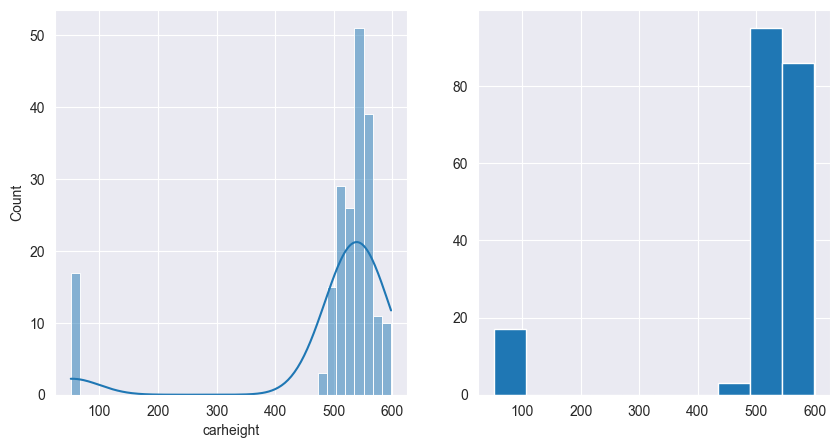

In [1622]:
hist_plot_continuous_variable(df_new, 'carheight')

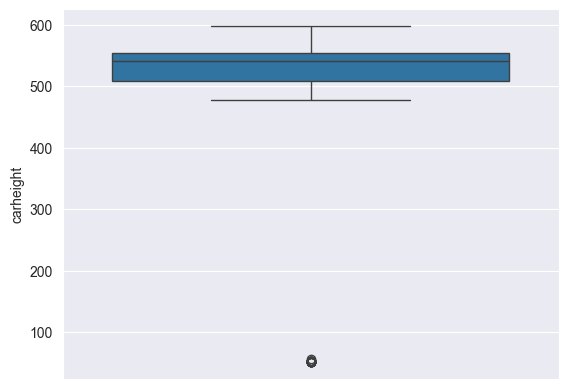

In [1623]:
sns.boxplot(df_new['carheight'])

plt.show()

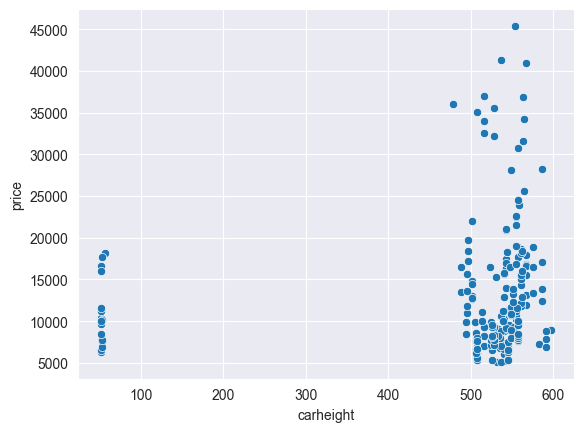

In [1624]:
sns.scatterplot(df_new, x='carheight', y='price')

plt.show()

Xe cao không có nghĩa là giá cao => loại bỏ yếu tố này khi xây dựng model

### 4.14. Phân tích tình hình giá cả theo curbweight (trọng lượng xe)

In [1625]:
all_infomation_continuous_variable(df_new, 'curbweight')

Các thông số thống kê cơ bản của curbweight
count     201.000000
mean     2555.666667
std       517.296727
min      1488.000000
25%      2169.000000
50%      2414.000000
75%      2926.000000
max      4066.000000
Name: curbweight, dtype: float64
curbweight Median: 2414.0
curbweight Mode: 0    2385
Name: curbweight, dtype: int64
curbweight Q1: 2169.0
curbweight Q3: 2926.0
curbweight IQR: 757.0
curbweight Range: 2578
curbweight Var: 267595.90333333367
curbweight Std: 517.2967265828518
curbweight Skew: 0.7058035875297635
curbweight Kurtosis: 0.034915576048686336
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 2
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột curbweight là 0.9950248756218906


Không có Outlier

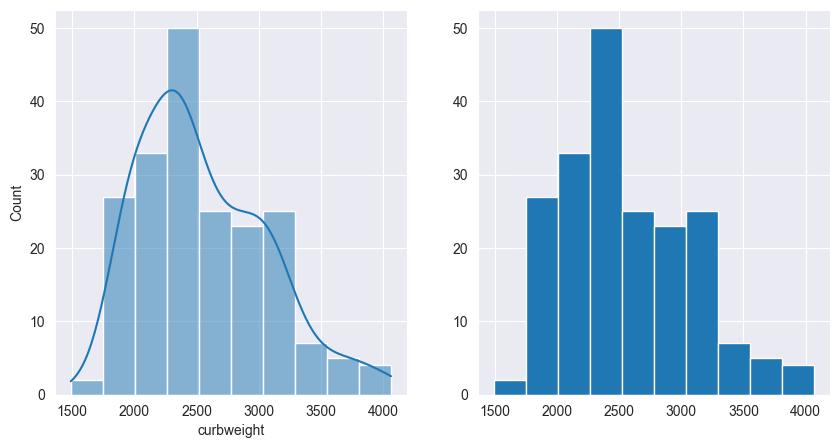

In [1626]:
hist_plot_continuous_variable(df_new, 'curbweight')

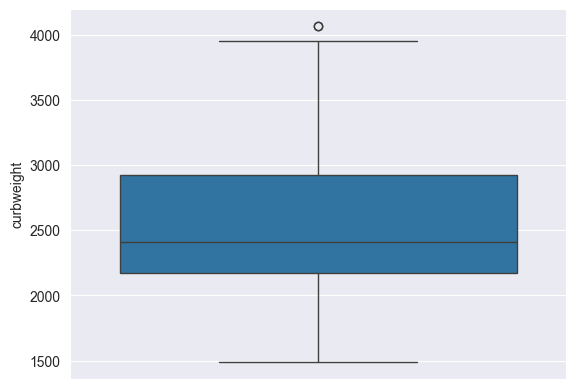

In [1627]:
sns.boxplot(df_new['curbweight'])

plt.show()

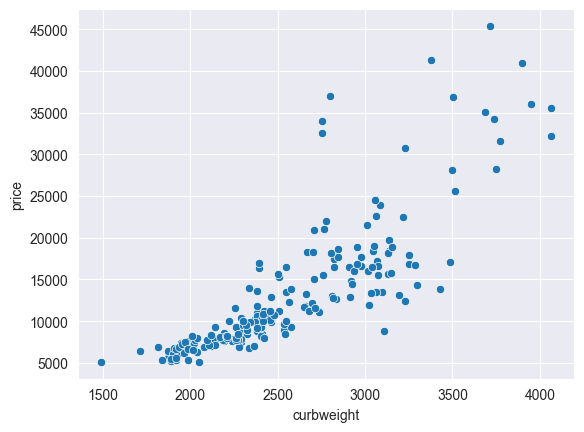

In [1628]:
sns.scatterplot(df_new, x='curbweight', y='price')

plt.show()

Xe càng nặng thì giá càng cao => liên quan đến giá xe

### 4.15. Phân tích tình hình giá cả theo enginetype (loại động cơ)

enginetype
ohc      145
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
Name: count, dtype: int64
-------------------------------------------


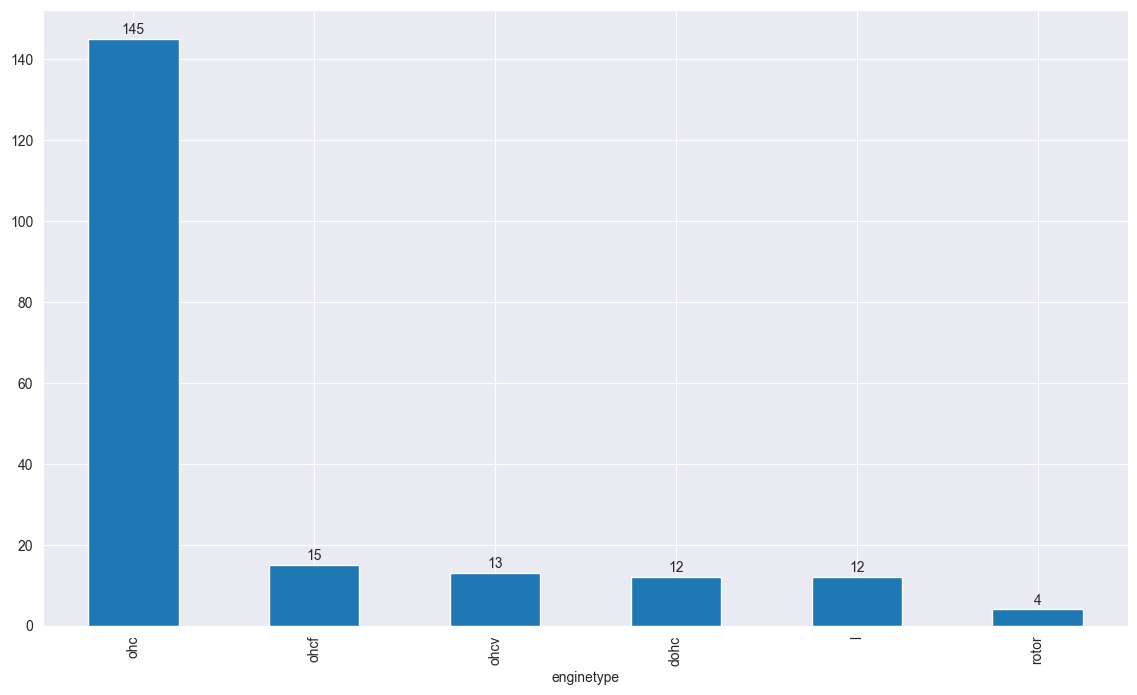

In [1629]:
all_infomation_categorical_variable(df_new, 'enginetype')

In [1630]:
df_new['enginetype'].unique()

array(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf'], dtype=object)

In [1631]:
df_new['enginetype'].value_counts()

enginetype
ohc      145
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
Name: count, dtype: int64

In [1632]:
df_new.groupby(['enginetype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

,enginetype,mean_price,median_price,total_count
0,ohcv,25098.384615,19699.0,13
1,dohc,18116.416667,16249.0,12
2,l,14627.583333,16105.0,12
3,ohcf,13738.600000,9233.0,15
4,rotor,13020.000000,12745.0,4
5,ohc,11567.358621,9095.0,145


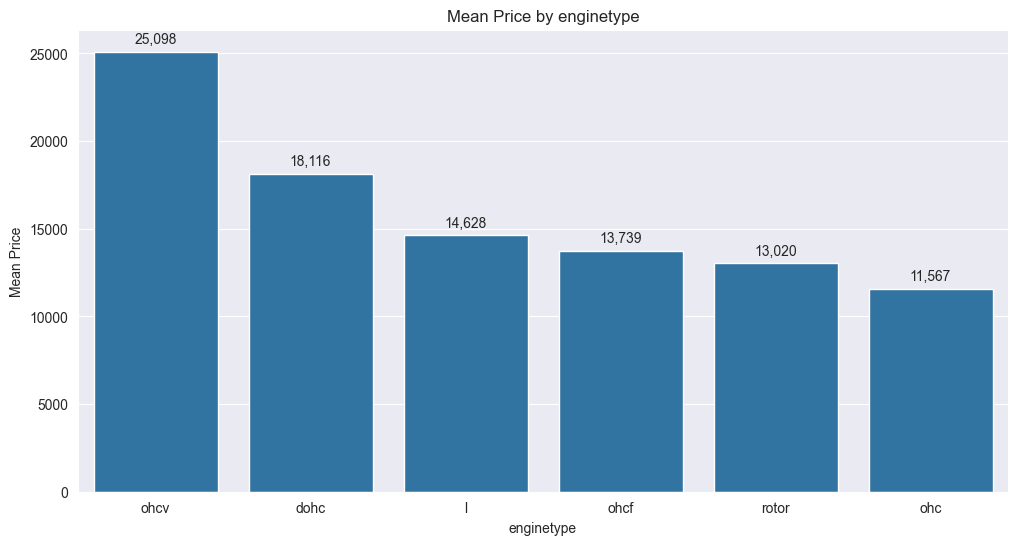

In [1633]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['enginetype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='enginetype', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by enginetype')
plt.xlabel('enginetype')
plt.ylabel('Mean Price')

plt.show()

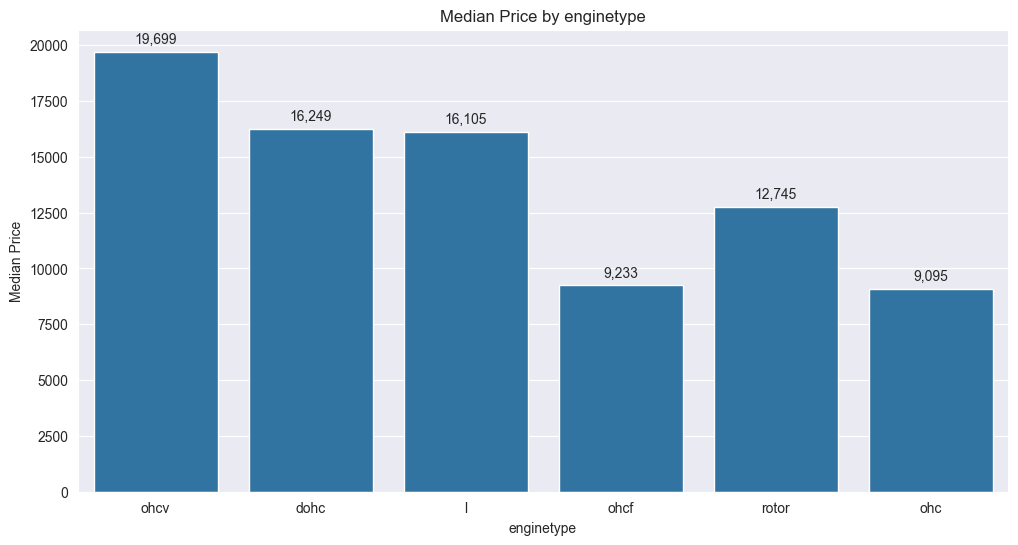

In [1634]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['enginetype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='enginetype', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by enginetype')
plt.xlabel('enginetype')
plt.ylabel('Median Price')

plt.show()

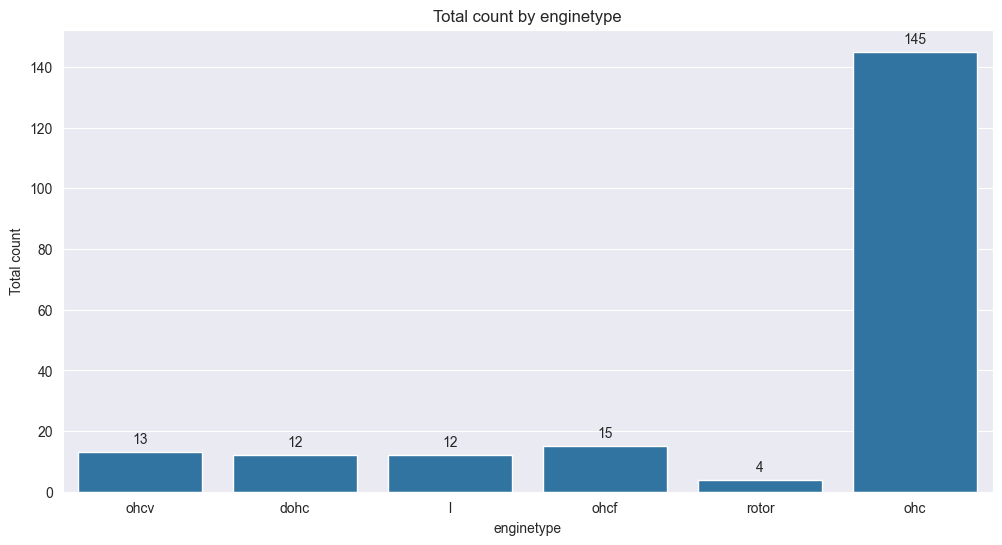

In [1635]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['enginetype']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='enginetype', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by enginetype')
plt.xlabel('enginetype')
plt.ylabel('Total count')

plt.show()

- DOHC: Double Overhead Camshaft - Hai trục cam trên đầu.
- OHCV: OverHead Camshaft Valve - Van trên đầu được điều khiển bởi trục cam.
- OHC: OverHead Camshaft - Trục cam trên đầu.
- L: Là một động cơ trục đơn được sử dụng bởi Mazda, thường được sử dụng cho động cơ rotor của họ.
- Rotor: Đây là loại động cơ đặc biệt, thường được sử dụng trong các xe máy bay và trong các mẫu xe đặc biệt như Mazda RX-7.
- OHCF: OverHead Camshaft Valve, Front-wheel drive - Điều khiển van trên đầu, dẫn động cầu trước.

Việc sử dụng các loại động cơ khác nhau có ảnh hưởng đến giá thành của xe

### 4.16. Phân tích tình hình giá cả theo cylindernumber (số lượng xi lanh trong động cơ)

In [1636]:
all_infomation_continuous_variable(df_new, 'cylindernumber')

Các thông số thống kê cơ bản của cylindernumber
count    201.000000
mean       4.363184
std        1.059452
min        2.000000
25%        4.000000
50%        4.000000
75%        4.000000
max       12.000000
Name: cylindernumber, dtype: float64
cylindernumber Median: 4.0
cylindernumber Mode: 0    4
Name: cylindernumber, dtype: int64
cylindernumber Q1: 4.0
cylindernumber Q3: 4.0
cylindernumber IQR: 0.0
cylindernumber Range: 10
cylindernumber Var: 1.1224378109452715
cylindernumber Std: 1.0594516557848552
cylindernumber Skew: 2.899682570707958
cylindernumber Kurtosis: 14.972743778146773
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 39
Số lượng Outlier bên dưới là: 5
Phần trăm Outlier của cột cylindernumber là 21.890547263681594


Không có Outlier

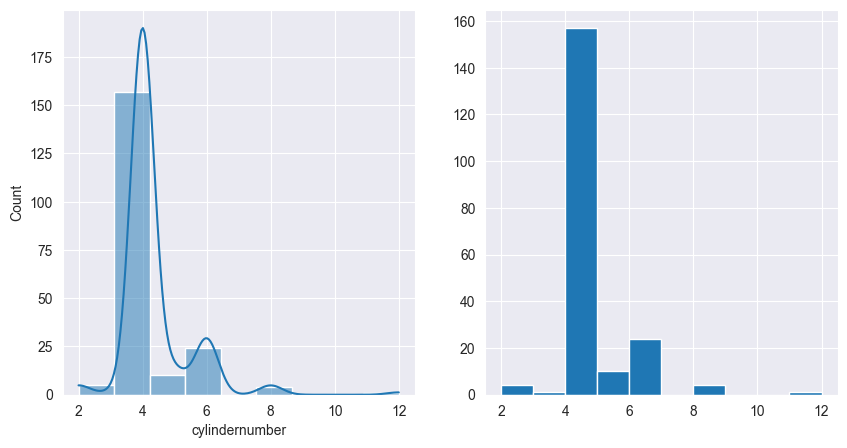

In [1637]:
hist_plot_continuous_variable(df_new, 'cylindernumber')

Các xe chủ yếu là có 4 xi lanh trong động cơ => cylindernumber về bản chất là 1 biến phân loại. Ta sẽ thử kiểm tra xem có nhiều xi lanh động cơ có làm giá xe cao hơn không?

In [1638]:
df_new.groupby(['cylindernumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

,cylindernumber,mean_price,median_price,total_count
0,8,38900.000000,38008.0,4
1,12,36000.000000,36000.0,1
2,6,23671.833333,21037.5,24
3,5,22007.600000,21397.5,10
4,2,13020.000000,12745.0,4
5,4,10303.197452,8949.0,157
6,3,5151.000000,5151.0,1


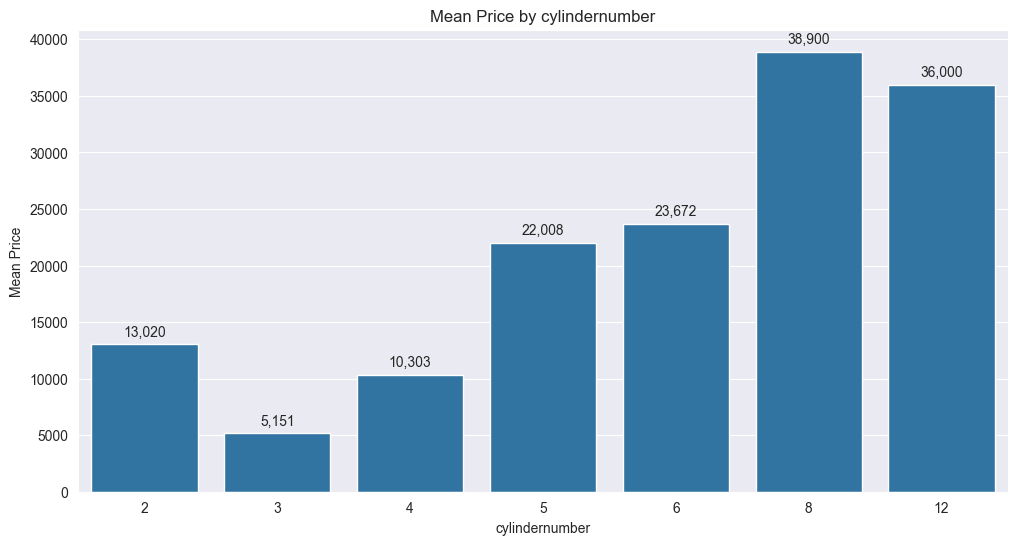

In [1639]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['cylindernumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='cylindernumber', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by cylindernumber')
plt.xlabel('cylindernumber')
plt.ylabel('Mean Price')

plt.show()

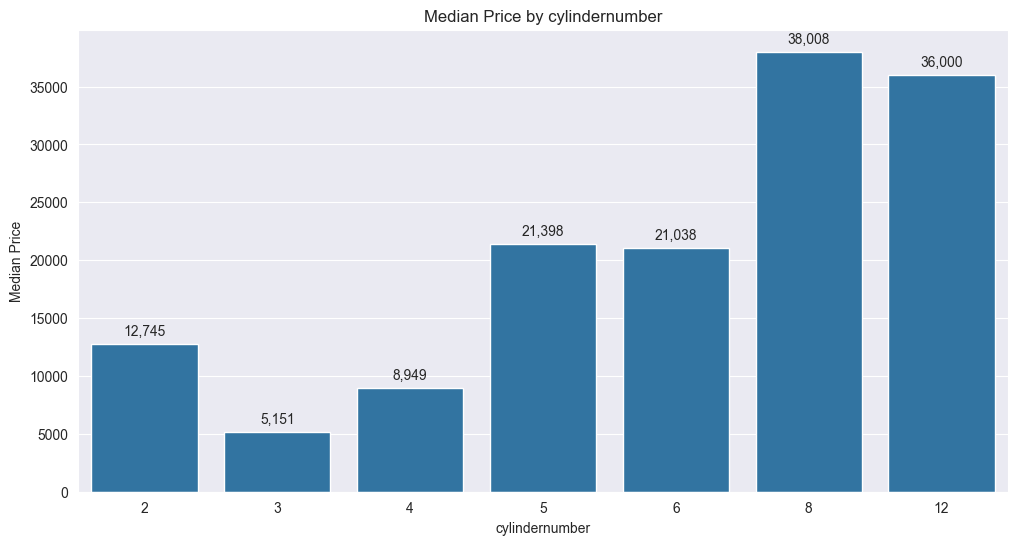

In [1640]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['cylindernumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='cylindernumber', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by cylindernumber')
plt.xlabel('cylindernumber')
plt.ylabel('Median Price')

plt.show()

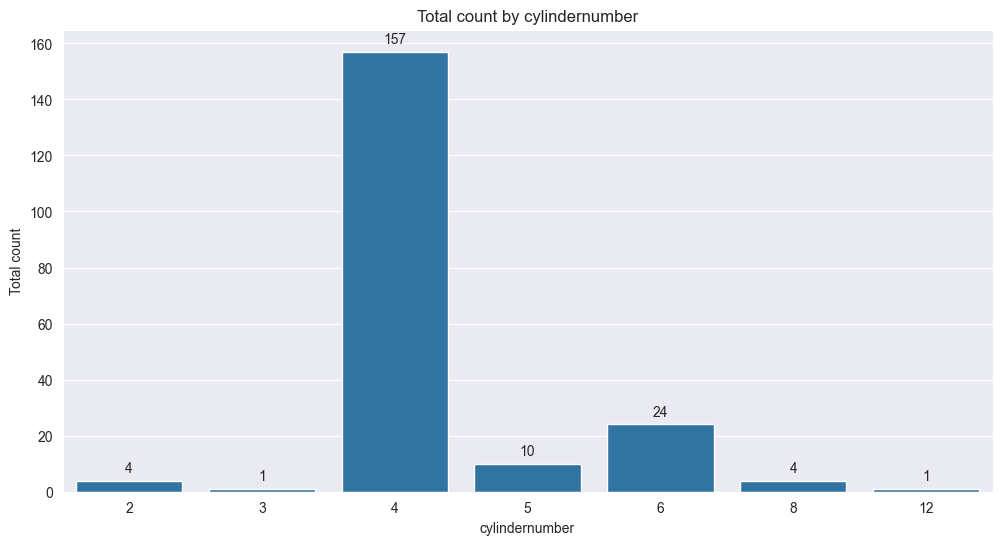

In [1641]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['cylindernumber']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='cylindernumber', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by cylindernumber')
plt.xlabel('cylindernumber')
plt.ylabel('Total count')

plt.show()

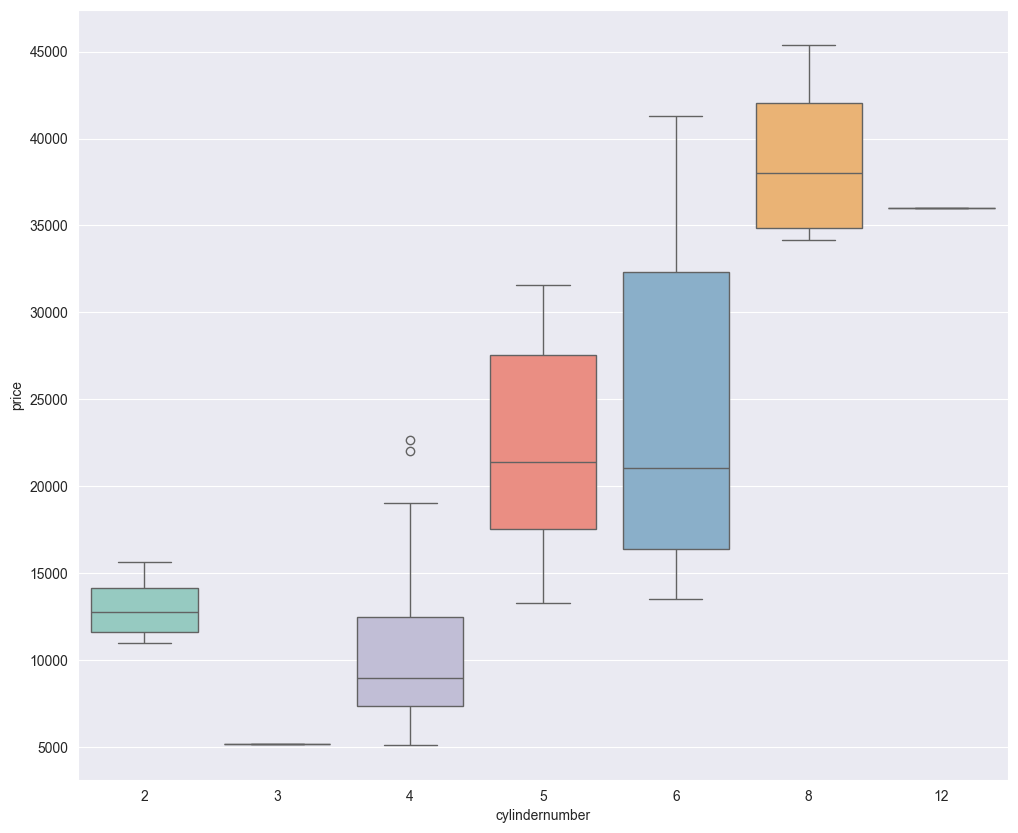

----------------------------------------
Kiểm tra 2 biến price và cylindernumber có phụ thuộc không?
2 cột price và cylindernumber có phụ thuộc
----------------------------------------
Sử dụng tukeyhsd
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
     2      3    -7869.0 0.7832 -24229.6448  8491.6448  False
     2      4 -2716.8025 0.9297 -10126.1255  4692.5204  False
     2      5     8987.6 0.0362    330.3605 17644.8395   True
     2      6 10651.8333 0.0016   2748.8911 18554.7756   True
     2      8    25880.0    0.0  15532.6197 36227.3803   True
     2     12    22980.0 0.0008   6619.3552 39340.6448   True
     3      4  5152.1975 0.9426  -9527.7373 19832.1322  False
     3      5    16856.6 0.0212   1508.9548 32204.2452   True
     3      6 18520.8333 0.0052   3585.6763 33455.9903   True
     3      8    33749.0    0.0  17388.3552 50109.6448

In [1642]:
all_infomation_categorical_vs_continuous(df_new, 'price', 'cylindernumber', 'cylindernumber ~ C(price)')

Ta có thể nhận thấy không phải có nhiều động cơ xi lanh mà giá xe sẽ càng cao nhưng đây cũng là 1 yếu tố ảnh hưởng tới giá xe

### 4.17. Phân tích tình hình giá cả theo enginesize (dung tích xi lanh của động cơ)

In [1643]:
all_infomation_continuous_variable(df_new, 'enginesize')

Các thông số thống kê cơ bản của enginesize
count    201.000000
mean     126.875622
std       41.546834
min       61.000000
25%       98.000000
50%      120.000000
75%      141.000000
max      326.000000
Name: enginesize, dtype: float64
enginesize Median: 120.0
enginesize Mode: 0     92
1    122
Name: enginesize, dtype: int64
enginesize Q1: 98.0
enginesize Q3: 141.0
enginesize IQR: 43.0
enginesize Range: 265
enginesize Var: 1726.1394527363163
enginesize Std: 41.54683444904457
enginesize Skew: 1.9791441966363523
enginesize Kurtosis: 5.497490766643349
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 10
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột enginesize là 4.975124378109453


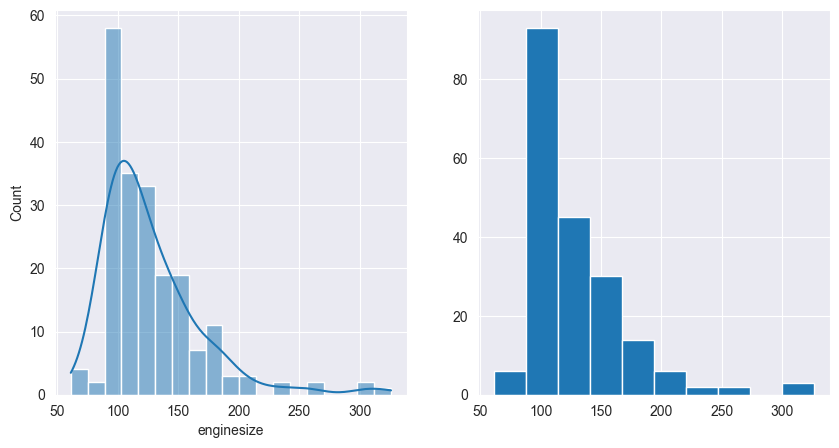

In [1644]:
hist_plot_continuous_variable(df_new, 'enginesize')

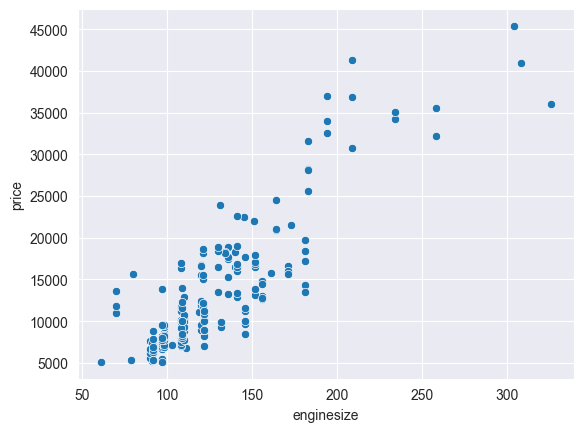

In [1645]:
sns.scatterplot(df_new, x='enginesize', y='price')

plt.show()

Xu hướng là động cơ xe càng lớn thì giá xe càng cao

### 4.18. Phân tích tình hình giá cả theo fuelsystem (hệ thống cung cấp nhiên liệu)

In [1646]:
df_new['fuelsystem'].unique().tolist()

['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', '4bbl', 'idi', 'spdi']

MPFI: Multi-Point Fuel Injection - Hệ thống phun nhiên liệu đa điểm. Hệ thống này cung cấp nhiên liệu trực tiếp vào mỗi xi-lanh của động cơ, cung cấp điều khiển chính xác và hiệu quả cao hơn so với các hệ thống truyền thống.

2BBL: Two-Barrel Carburetor - Carburetor hai ống hút. Carburetor này có hai ống hút nhiên liệu, được sử dụng để phun nhiên liệu vào buồng đốt của động cơ.

MFI: Multi-Port Fuel Injection - Phun nhiên liệu từng điểm. Tương tự như MPFI, MFI là hệ thống phun nhiên liệu đa điểm.

1BBL: One-Barrel Carburetor - Carburetor một ống hút. Carburetor này có một ống hút nhiên liệu, được sử dụng để phun nhiên liệu vào buồng đốt của động cơ.

SPFI: Single-Point Fuel Injection - Hệ thống phun nhiên liệu đơn điểm. Hệ thống này cung cấp nhiên liệu vào một điểm duy nhất, thường là trên bộ phân phối hoặc ống hút của động cơ.

4BBL: Four-Barrel Carburetor - Carburetor bốn ống hút. Carburetor này có bốn ống hút nhiên liệu, được sử dụng để phun nhiên liệu vào buồng đốt của động cơ.

IDI: Indirect Injection - Phun nhiên liệu gián tiếp. Hệ thống này phun nhiên liệu vào một không gian phụ trợ trước khi nó được đưa vào buồng đốt của động cơ.

SPDI: Single-Point Direct Injection - Phun nhiên liệu đơn điểm trực tiếp. Hệ thống này phun nhiên liệu trực tiếp vào buồng đốt của động cơ.

In [1647]:
df_new.groupby(['fuelsystem']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

,fuelsystem,mean_price,median_price,total_count
0,mpfi,17605.141304,15867.5,92
1,idi,15838.150000,13852.5,20
2,mfi,12964.000000,12964.0,1
3,4bbl,12145.000000,11845.0,3
4,spfi,11048.000000,11048.0,1
5,spdi,10990.444444,9959.0,9
6,1bbl,7555.545455,7295.0,11
7,2bbl,7433.203125,7324.0,64


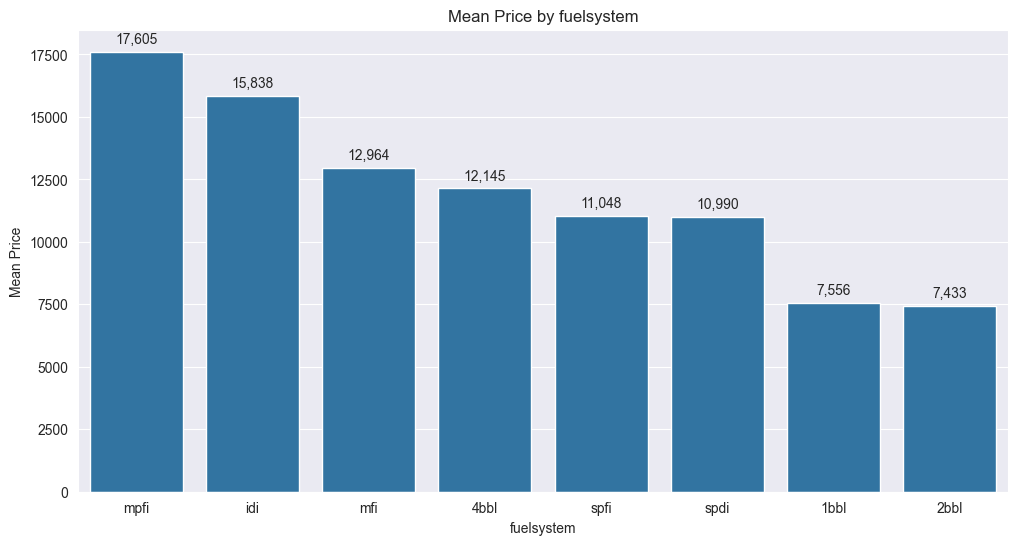

In [1648]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fuelsystem']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='fuelsystem', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by fuelsystem')
plt.xlabel('fuelsystem')
plt.ylabel('Mean Price')

plt.show()

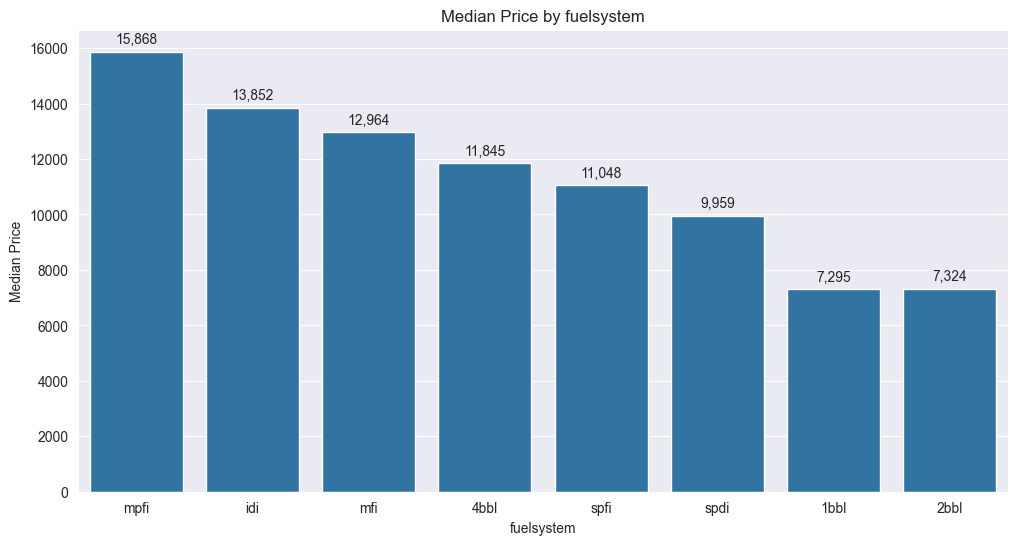

In [1649]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fuelsystem']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='fuelsystem', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by fuelsystem')
plt.xlabel('fuelsystem')
plt.ylabel('Median Price')

plt.show()

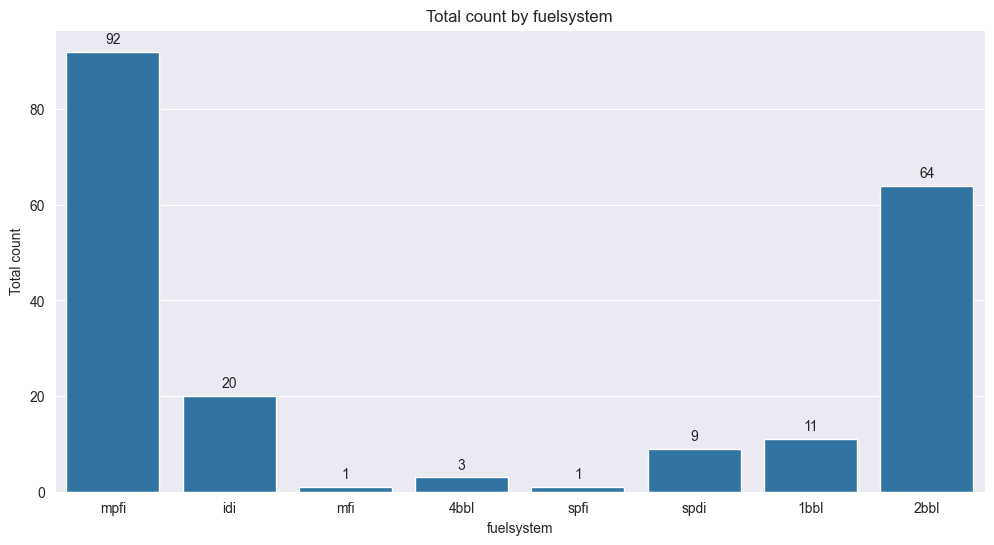

In [1650]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['fuelsystem']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='fuelsystem', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total count by fuelsystem')
plt.xlabel('fuelsystem')
plt.ylabel('Total count')

plt.show()

MPFI (Multi-Point Fuel Injection): Hệ thống phun nhiên liệu đa điểm cung cấp nhiên liệu một cách chính xác cho mỗi xi lanh. Đây là một hệ thống phun nhiên liệu tiên tiến, giúp tăng hiệu quả đốt cháy và giảm lượng khí thải, thường được tìm thấy trên các xe hiện đại.

SPDI (Single-Point Direct Injection): Dù chỉ phun nhiên liệu vào một điểm trực tiếp trong xi lanh, nhưng do là phun trực tiếp nên cũng khá hiệu quả và tiên tiến, thường xuất hiện trên các xe có giá trị kinh tế cao.

MFI (Multi-Port Fuel Injection): Tương tự như MPFI nhưng thường được xem là một phiên bản ít phổ biến hơn. Nó vẫn mang lại hiệu suất đốt cháy tốt và hiệu quả nhiên liệu.

SPFI (Single-Point Fuel Injection): Phun nhiên liệu đơn điểm không chính xác bằng các hệ thống phun đa điểm nhưng vẫn tốt hơn so với các hệ thống carburetor.

IDI (Indirect Injection): Phun nhiên liệu gián tiếp không hiệu quả bằng phun trực tiếp nhưng vẫn được sử dụng rộng rãi trên các động cơ diesel.

4BBL (Four-Barrel Carburetor): Carburetor bốn ống hút thường được tìm thấy trên các xe cổ hoặc xe hiệu suất cao từ thời kỳ trước khi hệ thống phun nhiên liệu trở nên phổ biến.

2BBL (Two-Barrel Carburetor): Carburetor hai ống hút là một lựa chọn kinh tế hơn so với carburetor bốn ống hút, vẫn cung cấp hiệu suất đủ dùng nhưng không cao.

1BBL (One-Barrel Carburetor): Carburetor một ống hút là loại đơn giản nhất và thường chỉ được sử dụng trên các loại xe cũ hoặc xe có giá rẻ.

Dựa vào đây ta sẽ biến cột dữ liệu thành dạng Ordinal với thứ tự sắp xếp như đoạn trên

### 4.19. Phân tích tình hình giá cả theo boreratio (tỷ lệ đường kính piston so với hành trình piston)

In [1651]:
all_infomation_continuous_variable(df_new, 'boreratio')

Các thông số thống kê cơ bản của boreratio
count    201.000000
mean     316.636816
std       69.111666
min       35.000000
25%      305.000000
50%      327.000000
75%      354.000000
max      394.000000
Name: boreratio, dtype: float64
boreratio Median: 327.0
boreratio Mode: 0    362.0
Name: boreratio, dtype: float64
boreratio Q1: 305.0
boreratio Q3: 354.0
boreratio IQR: 49.0
boreratio Range: 359.0
boreratio Var: 4776.4224378109375
boreratio Std: 69.11166643780872
boreratio Skew: -3.257921623859004
boreratio Kurtosis: 10.911299062909803
Phân phối lệch trái
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 0
Số lượng Outlier bên dưới là: 10
Phần trăm Outlier của cột boreratio là 4.975124378109453


Tỷ lệ outlier nhỏ (4.27%). Mean và Median có sự chênh lệch không đáng kể

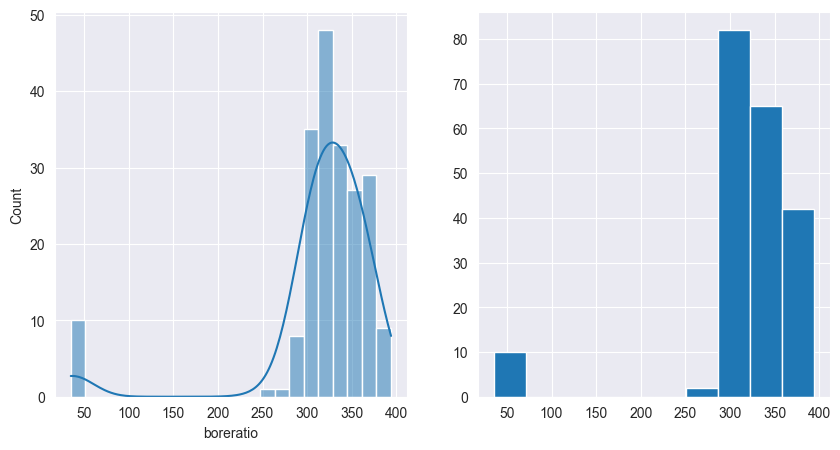

In [1652]:
hist_plot_continuous_variable(df_new, 'boreratio')

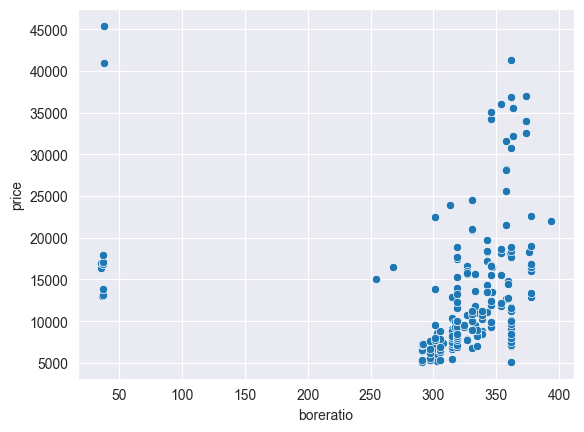

In [1653]:
sns.scatterplot(df_new, x='boreratio', y='price')

plt.show()

boreratio cao không có nghĩa là giá xe cao => loại bỏ feature này khi xây dựng mô hình

### 4.20. Phân tích tình hình giá cả theo stroke (hành trình của piston trong xi lanh của động cơ)

In [1654]:
all_infomation_continuous_variable(df_new, 'stroke')

Các thông số thống kê cơ bản của stroke
count     201.000000
mean      331.238806
std       432.861598
min        28.000000
25%       268.000000
50%       319.000000
75%       339.000000
max      3255.000000
Name: stroke, dtype: float64
stroke Median: 319.0
stroke Mode: 0    34.0
Name: stroke, dtype: float64
stroke Q1: 268.0
stroke Q3: 339.0
stroke IQR: 71.0
stroke Range: 3227.0
stroke Var: 187369.16268656738
stroke Std: 432.86159761125424
stroke Skew: 6.167236756421735
stroke Kurtosis: 39.892281779341396
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 4
Số lượng Outlier bên dưới là: 35
Phần trăm Outlier của cột stroke là 19.402985074626866


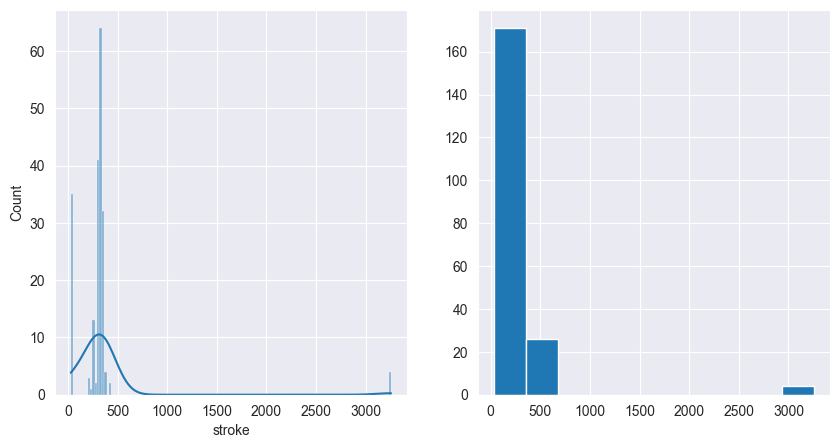

In [1655]:
hist_plot_continuous_variable(df_new, 'stroke')

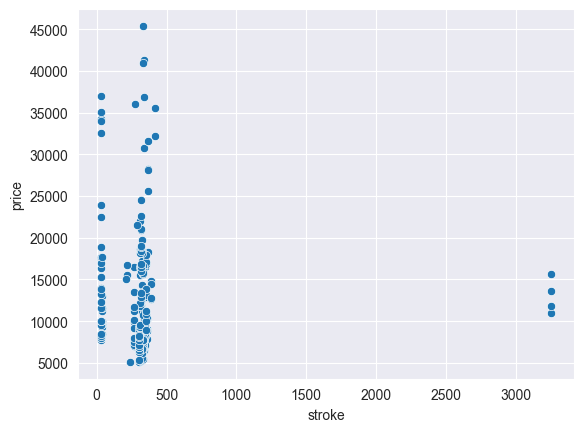

In [1656]:
sns.scatterplot(df_new, x='stroke', y='price')

plt.show()

stroke không ảnh hưởng đến giá xe

### 4.21. Phân tích tình hình giá cả theo compressionratio (Tỷ lệ nén)

In [1657]:
all_infomation_continuous_variable(df_new, 'compressionratio')

Các thông số thống kê cơ bản của compressionratio
count    201.000000
mean      75.009950
std      100.115882
min        7.000000
25%        9.000000
50%       85.000000
75%       94.000000
max      941.000000
Name: compressionratio, dtype: float64
compressionratio Median: 85.0
compressionratio Mode: 0    9.0
Name: compressionratio, dtype: float64
compressionratio Q1: 9.0
compressionratio Q3: 94.0
compressionratio IQR: 85.0
compressionratio Range: 934.0
compressionratio Var: 10023.189900497513
compressionratio Std: 100.11588235888206
compressionratio Skew: 6.467389195082234
compressionratio Kurtosis: 53.60350286788183
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 6
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột compressionratio là 2.9850746268656714


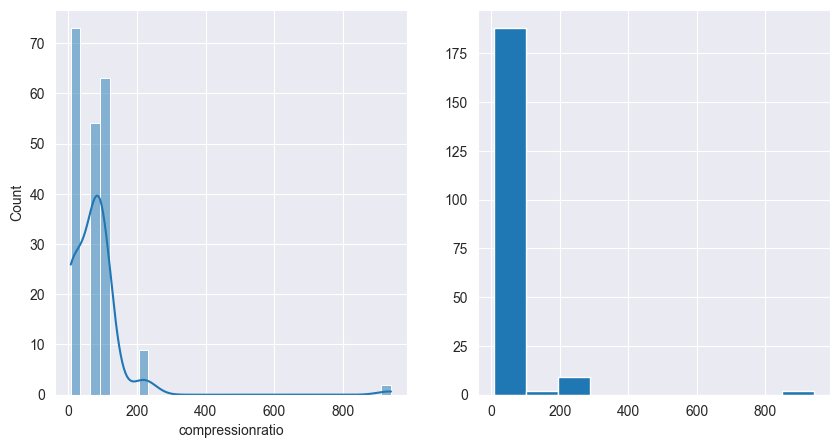

In [1658]:
hist_plot_continuous_variable(df_new, 'compressionratio')

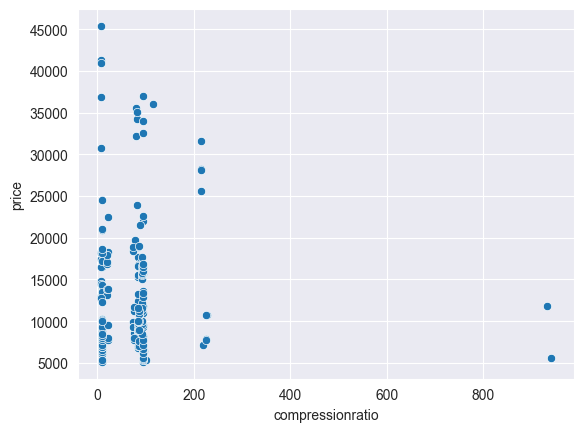

In [1659]:
sns.scatterplot(df_new, x='compressionratio', y='price')

plt.show()

compressionratio không ảnh hưởng đến giá xe

### 4.22. Phân tích tình hình giá cả theo horsepower (Mã lực)

In [1660]:
all_infomation_continuous_variable(df_new, 'horsepower')

Các thông số thống kê cơ bản của horsepower
count    201.000000
mean     103.263682
std       37.389372
min       48.000000
25%       70.000000
50%       95.000000
75%      116.000000
max      262.000000
Name: horsepower, dtype: float64
horsepower Median: 95.0
horsepower Mode: 0    68
Name: horsepower, dtype: int64
horsepower Q1: 70.0
horsepower Q3: 116.0
horsepower IQR: 46.0
horsepower Range: 214
horsepower Var: 1397.9651243781086
horsepower Std: 37.38937181042373
horsepower Skew: 1.1553715777806066
horsepower Kurtosis: 1.327302314200054
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 5
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột horsepower là 2.4875621890547266


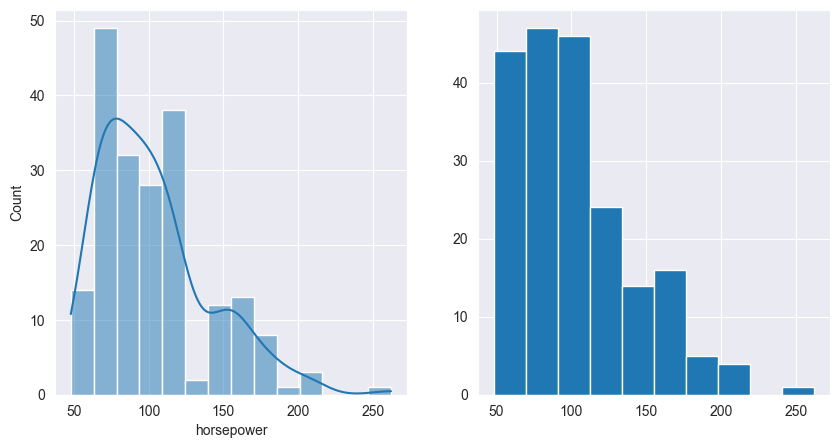

In [1661]:
hist_plot_continuous_variable(df_new, 'horsepower')

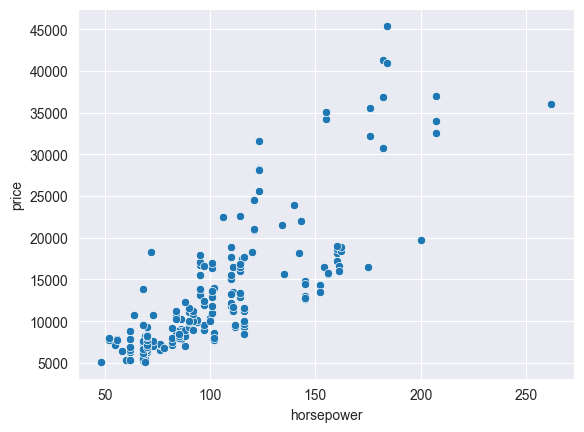

In [1662]:
# mã lực càng cao thì xe có giá càng cao
sns.scatterplot(df_new, x='horsepower', y='price')

plt.show()

horsepower càng cao thì xe có giá càng cao

### 4.23. Phân tích tình hình giá cả theo peakrpm (Vòng quay tối đa)

In [1663]:
all_infomation_continuous_variable(df_new, 'peakrpm')

Các thông số thống kê cơ bản của peakrpm
count     201.000000
mean     5117.412935
std       478.116381
min      4150.000000
25%      4800.000000
50%      5100.000000
75%      5500.000000
max      6600.000000
Name: peakrpm, dtype: float64
peakrpm Median: 5100.0
peakrpm Mode: 0    4800
1    5500
Name: peakrpm, dtype: int64
peakrpm Q1: 4800.0
peakrpm Q3: 5500.0
peakrpm IQR: 700.0
peakrpm Range: 2450
peakrpm Var: 228595.2736318408
peakrpm Std: 478.1163808444977
peakrpm Skew: 0.10936751467669427
peakrpm Kurtosis: 0.10771680456521793
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 2
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột peakrpm là 0.9950248756218906


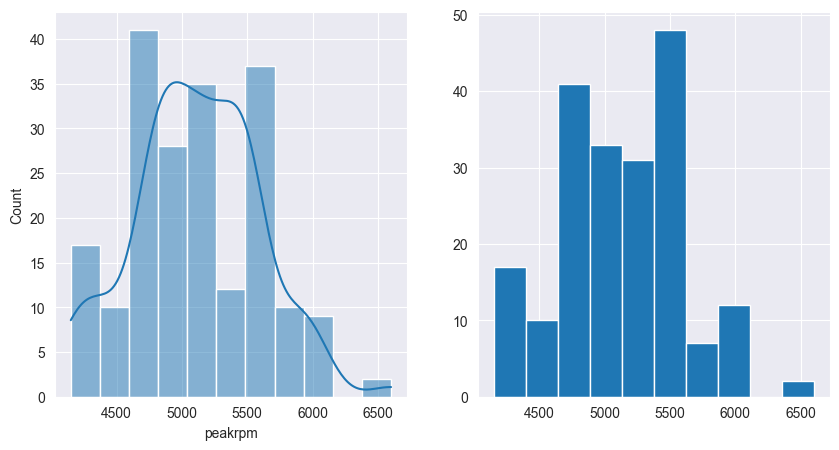

In [1664]:
hist_plot_continuous_variable(df_new, 'peakrpm')

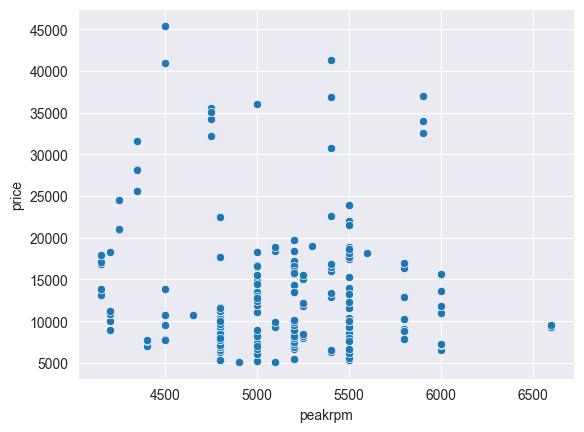

In [1665]:
sns.scatterplot(df_new, x='peakrpm', y='price')

plt.show()

pearkrpm không ảnh hưởng đến giá xe

### 4.24. Phân tích tình hình giá cả theo citympg (hiệu suất nhiên liệu của một xe hơi trong điều kiện lái xe thành phố hoặc đô thị)

In [1666]:
all_infomation_continuous_variable(df_new, 'citympg')

Các thông số thống kê cơ bản của citympg
count    201.000000
mean      25.179104
std        6.423220
min       13.000000
25%       19.000000
50%       24.000000
75%       30.000000
max       49.000000
Name: citympg, dtype: float64
citympg Median: 24.0
citympg Mode: 0    31
Name: citympg, dtype: int64
citympg Q1: 19.0
citympg Q3: 30.0
citympg IQR: 11.0
citympg Range: 36
citympg Var: 41.25776119402983
citympg Std: 6.4232204690505394
citympg Skew: 0.6804334707346078
citympg Kurtosis: 0.7539680878039432
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 2
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột citympg là 0.9950248756218906


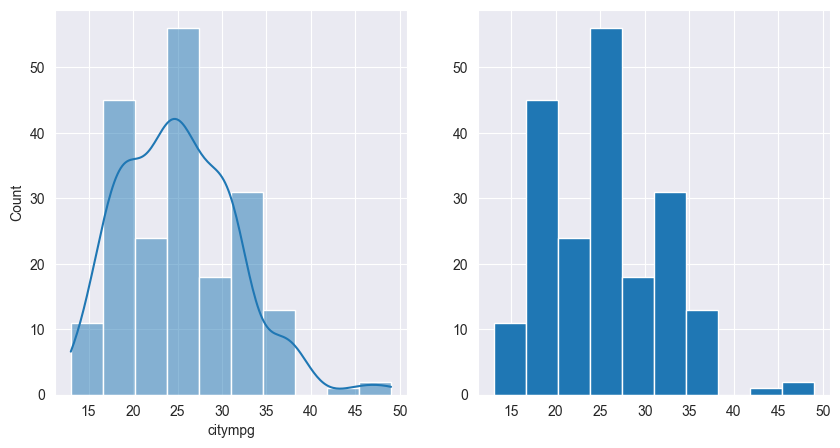

In [1667]:
hist_plot_continuous_variable(df_new, 'citympg')

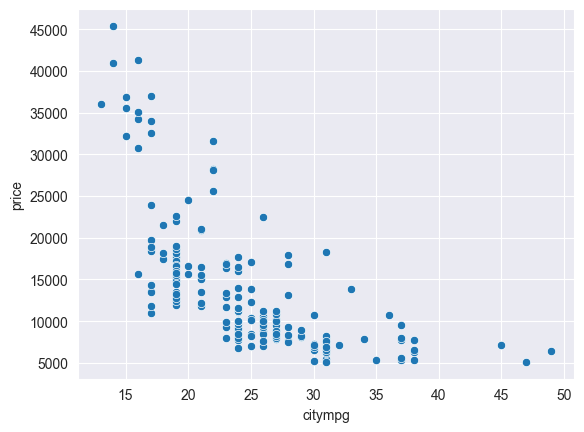

In [1668]:
sns.scatterplot(df_new, x='citympg', y='price')

plt.show()

### 4.25. Phân tích tình hình giá cả theo highwaympg (hiệu suất nhiên liệu của một xe hơi trong điều kiện lái xe trên đường cao tốc hoặc xa lộ)

In [1669]:
all_infomation_continuous_variable(df_new, 'highwaympg')

Các thông số thống kê cơ bản của highwaympg
count    201.000000
mean      30.686567
std        6.815150
min       16.000000
25%       25.000000
50%       30.000000
75%       34.000000
max       54.000000
Name: highwaympg, dtype: float64
highwaympg Median: 30.0
highwaympg Mode: 0    25
Name: highwaympg, dtype: int64
highwaympg Q1: 25.0
highwaympg Q3: 34.0
highwaympg IQR: 9.0
highwaympg Range: 38
highwaympg Var: 46.44626865671642
highwaympg Std: 6.815149936480959
highwaympg Skew: 0.5495071459179158
highwaympg Kurtosis: 0.5611711398011869
Phân phối lệch phải
--------------------------------------------------------
Kiểm tra số lượng Outlier!
Số lượng Outlier bên trên là: 3
Số lượng Outlier bên dưới là: 0
Phần trăm Outlier của cột highwaympg là 1.4925373134328357


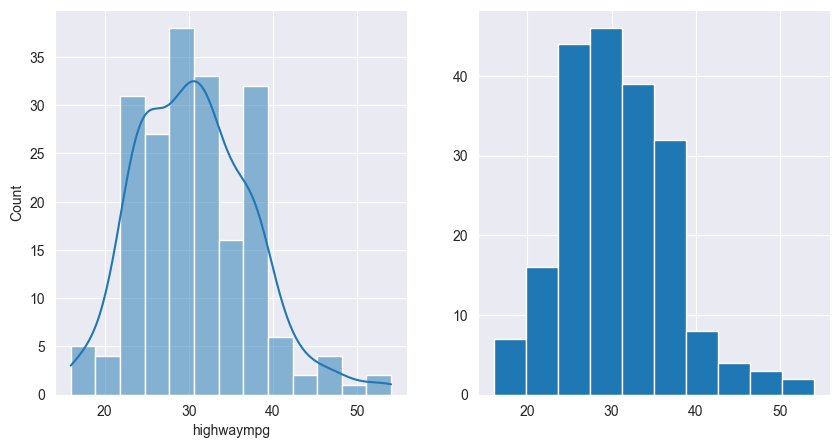

In [1670]:
hist_plot_continuous_variable(df_new, 'highwaympg')

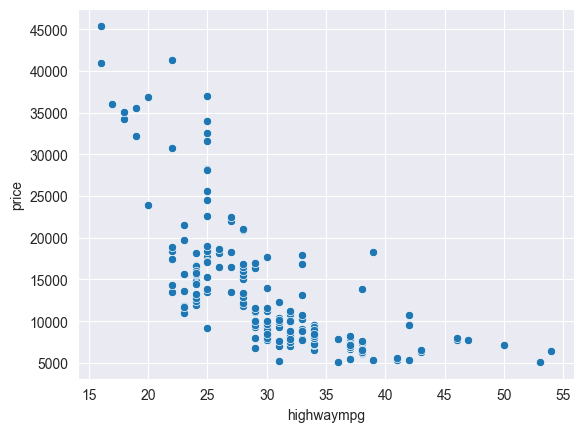

In [1671]:
sns.scatterplot(df_new, x='highwaympg', y='price')

plt.show()

highwaympg có ảnh hưởng đến giá xe. Xe nào càng tiêu thụ ít nhiên liệu thì giá càng cao

### 4.26. Phân tích tình hình giá cả theo CarCompany (Công ty sản xuất xe)

In [1672]:
df_new.groupby(['CarCompany']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index()

,CarCompany,mean_price,median_price,total_count
0,jaguar,34600.000000,35550.0,3
1,buick,33647.000000,32892.0,8
2,porsche,31400.500000,33278.0,4
3,bmw,26118.750000,22835.0,8
4,volvo,18063.181818,18420.0,11
5,audi,17859.166667,17580.0,6
6,mercury,16503.000000,16503.0,1
7,alfa-romero,15498.333333,16500.0,3
8,peugeot,15489.090909,16630.0,11
9,saab,15223.333333,15275.0,6


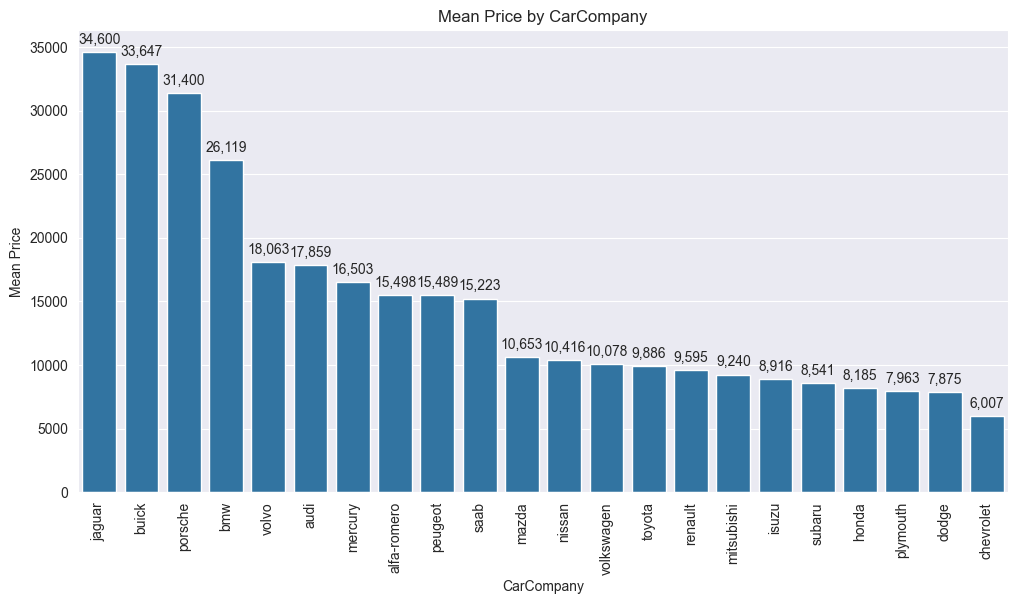

In [1673]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['CarCompany']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='CarCompany', y='mean_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Mean Price by CarCompany')
plt.xlabel('CarCompany')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)

plt.show()

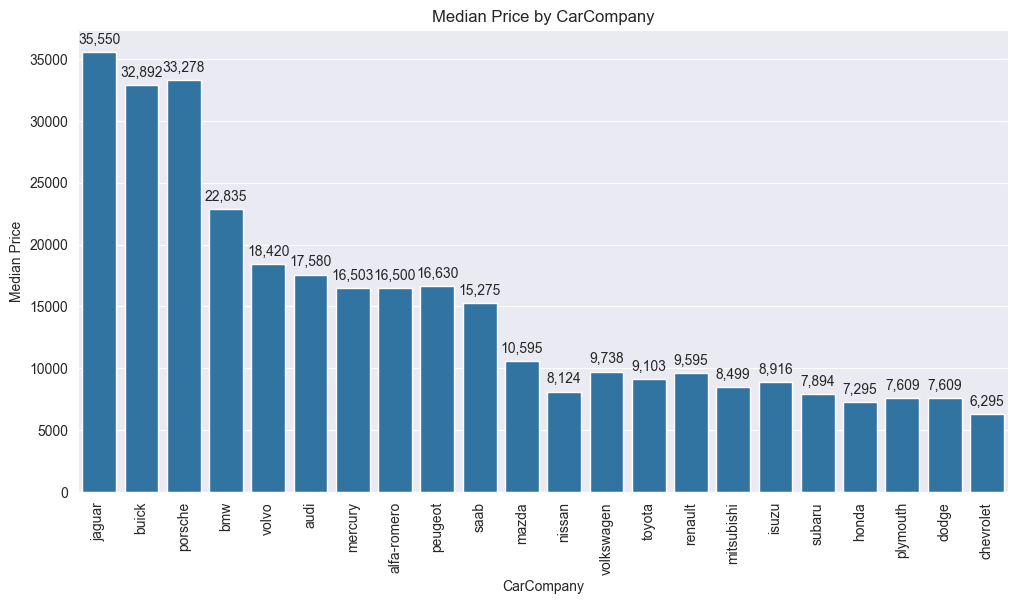

In [1674]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['CarCompany']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='CarCompany', y='median_price')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Median Price by CarCompany')
plt.xlabel('CarCompany')
plt.ylabel('Median Price')
plt.xticks(rotation=90)

plt.show()

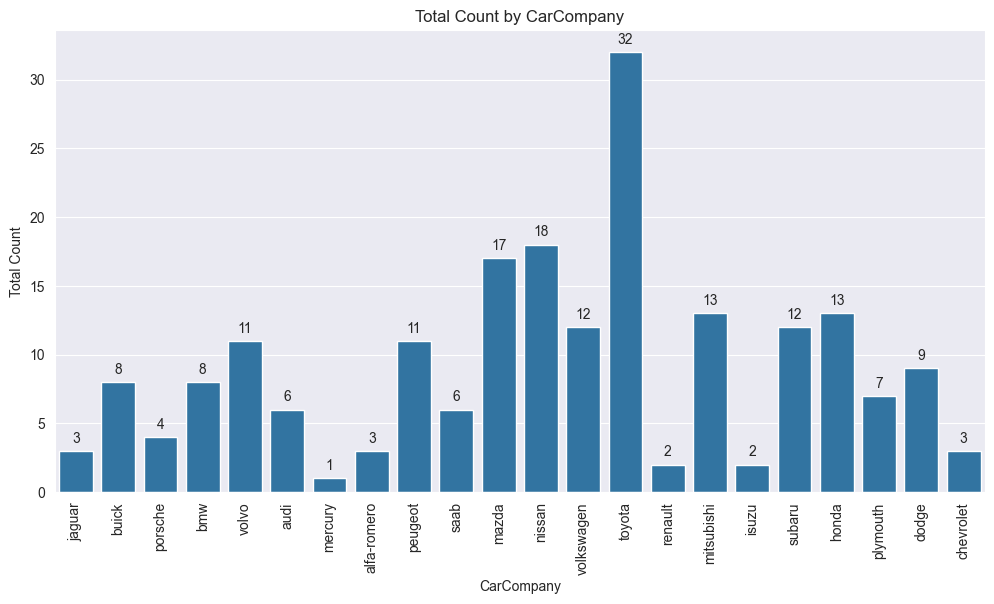

In [1675]:
plt.figure(figsize=(12,6))

ax = sns.barplot(df_new.groupby(['CarCompany']).agg(
    mean_price = ('price', 'mean'),
    median_price = ('price', np.median),
    total_count = ('price', 'count')
).sort_values(by='mean_price', ascending=False).reset_index(), x='CarCompany', y='total_count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Total Count by CarCompany')
plt.xlabel('CarCompany')
plt.ylabel('Total Count')
plt.xticks(rotation=90)

plt.show()

Thương hiệu xe theo công ty có ảnh hưởng đến giá bán xe. Như bạn thấy thì các thương hiệu lớn như porche luôn có giá bán cao hơn các hãng khác

Các feature có ảnh hưởng tới giá xe là:
- fueltype (map dữ liệu với diesel = 1, gas = 0)
- aspiration (map dữ liệu với turbo = 1, std = 0)
- carbody (Tiến hành One Hot Encoding cột này)
- drivewheel (map dữ liệu tới rwd = 2, 4wd = 1,  fwd = 0)
- curbweight (dữ liệu liên tục nên sẽ scale trước khi train mô hình - sẽ thử 2 trường hợp ko scale và scale xem sao)
- enginetype (Tiến hành One Hot Encoding cột này)
- cylindernumber (Tiến hành One Hot Encoding cột này)
- enginesize (dữ liệu liên tục nên sẽ scale trước khi train mô hình - sẽ thử 2 trường hợp ko scale và scale xem sao)
- fuelsystem (map lại dữ liệu với mpfi = 7, spdi = 6, mfi = 5, spfi = 4, idi = 3, 4bbl = 2, 2bbl = 1, 1bbl = 0)
- horsepower (dữ liệu liên tục nên sẽ scale trước khi train mô hình - sẽ thử 2 trường hợp ko scale và scale xem sao)
- citympg (dữ liệu liên tục nên sẽ scale trước khi train mô hình - sẽ thử 2 trường hợp ko scale và scale xem sao)
- highwaympg (dữ liệu liên tục nên sẽ scale trước khi train mô hình - sẽ thử 2 trường hợp ko scale và scale xem sao)
- CarCompany (Tiến hành One Hot Encoding)

## 5. Xây dựng mô hình dự đoán giá xe

### 5.1. Tiến hành lấy ra các feature cần thiết cho mô hình

In [1676]:
feature_choose = ['fueltype', 'aspiration', 'carbody', 'drivewheel', 'curbweight', 'enginetype', 
    'cylindernumber', 'enginesize', 'fuelsystem', 'horsepower', 'citympg', 'highwaympg', 'CarCompany', 'price']

In [1677]:
df_final = df_new[feature_choose]

df_final

,fueltype,aspiration,carbody,drivewheel,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,horsepower,citympg,highwaympg,CarCompany,price
0,gas,std,convertible,rwd,2548,dohc,4,130,mpfi,111,21,27,alfa-romero,13495.0
1,gas,std,convertible,rwd,2548,dohc,4,130,mpfi,111,21,27,alfa-romero,16500.0
2,gas,std,hatchback,rwd,2823,ohcv,6,152,mpfi,154,19,26,alfa-romero,16500.0
3,gas,std,sedan,fwd,2337,ohc,4,109,mpfi,102,24,30,audi,13950.0
4,gas,std,sedan,4wd,2824,ohc,5,136,mpfi,115,18,22,audi,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,gas,std,sedan,rwd,2952,ohc,4,141,mpfi,114,23,28,volvo,16845.0
201,gas,turbo,sedan,rwd,3049,ohc,4,141,mpfi,160,19,25,volvo,19045.0
202,gas,std,sedan,rwd,3012,ohcv,6,173,mpfi,134,18,23,volvo,21485.0
203,diesel,turbo,sedan,rwd,3217,ohc,6,145,idi,106,26,27,volvo,22470.0


In [1678]:
df_final['fueltype'] = df_final['fueltype'].map(
    {
        'diesel': 1,
        'gas': 0
    }
)

In [1679]:
df_final['aspiration'] = df_final['aspiration'].map(
    {
        'turbo': 1,
        'std': 0
    }
)

In [1680]:
df_final['drivewheel'] = df_final['drivewheel'].map(
    {
        'rwd': 2,
        '4wd': 1,
        'fwd': 0
    }
)

In [1681]:
df_final['fuelsystem'] = df_final['fuelsystem'].map(
    {
        'mpfi': 7,
        'spdi': 6,
        'mfi': 5,
        'spfi': 4,
        'idi': 3,
        '4bbl': 2,
        '2bbl': 1,
        '1bbl': 0
    }
)

In [1682]:
# các cột sẽ One Hot Encoding là: carbody, enginetype, cylindernumber, CarCompany
df_final = pd.get_dummies(df_final, columns=['carbody', 'enginetype', 'cylindernumber', 'CarCompany'], drop_first=False, dtype='int')

df_final

,fueltype,aspiration,drivewheel,curbweight,enginesize,fuelsystem,horsepower,citympg,highwaympg,price,...,CarCompany_nissan,CarCompany_peugeot,CarCompany_plymouth,CarCompany_porsche,CarCompany_renault,CarCompany_saab,CarCompany_subaru,CarCompany_toyota,CarCompany_volkswagen,CarCompany_volvo
0,0,0,2,2548,130,7,111,21,27,13495.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,2548,130,7,111,21,27,16500.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,2823,152,7,154,19,26,16500.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2337,109,7,102,24,30,13950.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,2824,136,7,115,18,22,17450.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0,0,2,2952,141,7,114,23,28,16845.0,...,0,0,0,0,0,0,0,0,0,1
201,0,1,2,3049,141,7,160,19,25,19045.0,...,0,0,0,0,0,0,0,0,0,1
202,0,0,2,3012,173,7,134,18,23,21485.0,...,0,0,0,0,0,0,0,0,0,1
203,1,1,2,3217,145,3,106,26,27,22470.0,...,0,0,0,0,0,0,0,0,0,1


In [1683]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, 0 to 204
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fueltype                201 non-null    int64  
 1   aspiration              201 non-null    int64  
 2   drivewheel              201 non-null    int64  
 3   curbweight              201 non-null    int64  
 4   enginesize              201 non-null    int64  
 5   fuelsystem              201 non-null    int64  
 6   horsepower              201 non-null    int64  
 7   citympg                 201 non-null    int64  
 8   highwaympg              201 non-null    int64  
 9   price                   201 non-null    float64
 10  carbody_convertible     201 non-null    int32  
 11  carbody_hardtop         201 non-null    int32  
 12  carbody_hatchback       201 non-null    int32  
 13  carbody_sedan           201 non-null    int32  
 14  carbody_wagon           201 non-null    int32  

### 5.2. Chia tập X, y => tập train và test

In [1684]:
X = df_final.drop(columns=target_var)

y = df_final[target_var]

In [1685]:
from sklearn.model_selection import train_test_split

In [1686]:
# Chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1687]:
R2_train = list()
R2_test = list()
Time_Running = list()

### 5.3. Xây dựng model với mô hình Linear Regression và test

In [1688]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [1689]:
start_time = time.time()

model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)

In [1690]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 10555930.07242978


In [1691]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 3248.989084689233


In [1692]:
# R2 Score cho kết quả là 0.888 => khá tốt
print(f'R2 Score: {r2_score(y_test, y_pred)}')

end_time = time.time()

R2_train.append(r2_score(y_train, model_linear.predict(X_train)))
R2_test.append(r2_score(y_test, y_pred))
Time_Running.append(round(end_time - start_time, 2))

R2 Score: 0.8886407277906978


### 5.4. Thử tuning mô hình với Adaboosting

In [1693]:
from sklearn.ensemble import AdaBoostRegressor

In [1694]:
start_time = time.time()

ada_reg_model = AdaBoostRegressor(estimator=model_linear, n_estimators=500, random_state=42, learning_rate=0.1)

ada_reg_model.fit(X_train, y_train)

y_pred = ada_reg_model.predict(X_test)

In [1695]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 9653958.12945051


In [1696]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 3107.081931563844


In [1697]:
# Kết quả thu được cao hơn so với ban đầu 1 chút (0.898)
print(f'R2 Score: {r2_score(y_test, y_pred)}')

end_time = time.time()

R2_train.append(r2_score(y_train, ada_reg_model.predict(X_train)))
R2_test.append(r2_score(y_test, y_pred))
Time_Running.append(round(end_time - start_time, 2))

R2 Score: 0.8981560370466506


### 5.5. Thử với mô hình Random Forest

In [1698]:
from sklearn.ensemble import RandomForestRegressor

In [1699]:
start_time = time.time()

model_random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

model_random_forest_regressor.fit(X_train, y_train)

y_pred = model_random_forest_regressor.predict(X_test)

In [1700]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 8325855.8577951845


In [1701]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 2885.455918532665


In [1702]:
# Kết quả cao hơn so với mô hình ban đầu.
print(f'R2 Score: {r2_score(y_test, y_pred)}')

R2 Score: 0.9121667875325161


In [1703]:
end_time = time.time()

R2_train.append(r2_score(y_train, model_random_forest_regressor.predict(X_train)))
R2_test.append(r2_score(y_test, y_pred))
Time_Running.append(round(end_time - start_time, 2))

In [1704]:
# Ta sẽ thử tuning bằng GridSearchCV
from sklearn.model_selection import GridSearchCV

In [1705]:
start_time = time.time()

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'max_depth': np.arange(3, 22, 2),  # Range of max_depth values from 3 to 21 with a step of 2
    'n_estimators': range(1, 22, 2),   # Range of n_estimators values from 1 to 21 with a step of 2
    'criterion': ['squared_error', 'absolute_error']        # Criterion options for RandomForestRegressor
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                         'n_estimators': range(1, 22, 2)})

In [1706]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 7, 'n_estimators': 21}


In [1707]:
rf_model_tuning = grid_search.best_estimator_

In [1708]:
y_pred = rf_model_tuning.predict(X_test)

In [1709]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 8166588.598924138


In [1710]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 2857.7243742047863


In [1711]:
# Đây là kết quả tốt nhất cho mô hình đến lúc này
print(f'R2 Score: {r2_score(y_test, y_pred)}')

end_time = time.time()

R2_train.append(r2_score(y_train, rf_model_tuning.predict(X_train)))
R2_test.append(r2_score(y_test, y_pred))
Time_Running.append(round(end_time - start_time, 2))

R2 Score: 0.9138469697535951


### 5.6. Thử với mô hình SVR

Với mô hình SVR thì ta sẽ cần phải scale dữ liệu trước khi chạy mô hình

In [1712]:
from sklearn.svm import SVR

In [1713]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [1714]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

In [1715]:
model_svr = SVR()

model_svr.fit(X_train_scaler, y_train)

y_pred = model_svr.predict(X_test_scaler)

In [1716]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 107204588.4843941


In [1717]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 10353.964867836577


In [1718]:
print(f'R2 Score: {r2_score(y_test, y_pred)}')

R2 Score: -0.13094960550187817


r2 score ra giá trị âm => ta sẽ điều chỉnh 1 chút để mô hình chạy tốt hơn

In [1719]:
start_time = time.time()

# Khởi tạo mô hình SVR
svr_model = SVR()

# Định nghĩa các siêu tham số cần tìm kiếm
param_grid = {
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 20, 30],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5, 1],
    'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search.fit(X_train_scaler, y_train)

# In ra các siêu tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 7, 'n_estimators': 21}


In [1720]:
svr_model_tuning = grid_search.best_estimator_

y_pred = svr_model_tuning.predict(X_test_scaler)

In [1721]:
print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')

Mean Square Error: 15137251.309764024


In [1722]:
print(f'Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Root Mean Square Error: 3890.6620657368876


In [1723]:
# Sau khi tuning thì kết quả mô hình đã tốt hơn nhưng vẫn không bằng Random Forest
print(f'R2 Score: {r2_score(y_test, y_pred)}')

end_time = time.time()

R2_train.append(r2_score(y_train, svr_model_tuning.predict(X_train_scaler)))
R2_test.append(r2_score(y_test, y_pred))
Time_Running.append(round(end_time - start_time, 2))

R2 Score: 0.8403103016467199


## 6. Kết luận

In [1724]:
R2_train

[0.9628848944096942,
 0.9636816662768102,
 0.9847627780028008,
 0.9753765482938286,
 0.9754496446723525]

In [1725]:
R2_test

[0.8886407277906978,
 0.8981560370466506,
 0.9121667875325161,
 0.9138469697535951,
 0.8403103016467199]

In [1726]:
Time_Running

[0.28, 0.58, 0.85, 3.11, 2.68]

In [1730]:
Technique = ["LinearRegression","Linear Regression + Adaboosting", "RandomForestRegressor", "RandomForestRegressor Tuning","SVR"]

results = pd.DataFrame({'Model': Technique,'R Squared(Train)': R2_train,'R Squared(Test)': R2_test, 'Time Running': Time_Running})

results = results.sort_values(by='R Squared(Test)', ascending=False).reset_index(drop=True)

display(results)

,Model,R Squared(Train),R Squared(Test),Time Running
0,RandomForestRegressor Tuning,0.975377,0.913847,3.11
1,RandomForestRegressor,0.984763,0.912167,0.85
2,Linear Regression + Adaboosting,0.963682,0.898156,0.58
3,LinearRegression,0.962885,0.888641,0.28
4,SVR,0.975450,0.840310,2.68
